In [ ]:
# !pip install waterfallcharts
!pip install ucimlrepo
!pip install fancyimpute

In [ ]:
!pip install geopandas matplotlib

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import chi2_contingency, chi2
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from fancyimpute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
import geopandas as gpd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
communities_df = pd.read_csv("/content/drive/MyDrive/Final-Project-CS105/dataset/communities.csv")
communities_df.replace('?', np.NaN, inplace=True)
communities_df.head()


,state,county,community,communityname,fold,population,householdsize,racePctBlack,racePctWhite,racePctAsian,...,popDens,pctUsePubTrans,policCars,policOperBudg,lemasPctPolicOnPatr,lemasGangUnitDeploy,lemasGangUnitDeploy.1,lemasPctOfficDrugUn,policBudgPerPop,violentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


# **Preprocessing for Correlation Analysis**

In [ ]:
corr_df = communities_df.copy()

column_to_impute = corr_df[['policOperBudg']]

imputing = IterativeImputer()
arr = imputing.fit_transform(column_to_impute)

new_df = pd.DataFrame(arr)

corr_df['policOperBudg'] = new_df

corr_df['policOperBudg'].dtype, corr_df['communityname'].dtype
corr_df['lemasPctPolicOnPatr'].dtype

corr_df['county'] = corr_df['county'].astype('category').dtypes
corr_df['community'] = corr_df['community'].astype('category').dtypes
corr_df['communityname'] = corr_df['communityname'].astype('category').dtypes

columns_to_iterate = corr_df.columns[4:]

#Imputing Missing Values
for column in columns_to_iterate:
    column_to_impute = corr_df[[column]]

    imputing = IterativeImputer()
    arr = imputing.fit_transform(column_to_impute)

    new_df = pd.DataFrame(arr)

    corr_df[column] = new_df

In [ ]:

violentCrimeCopy = pd.DataFrame()

violentCrimeCopy = corr_df['violentCrimesPerPop']

corr_df['CrimeRateCategory'] = violentCrimeCopy
def categorize_violent_crime(crime_rate):
    if crime_rate < 0.25:
        return 1  # Low
    elif 0.25 <= crime_rate < 0.50:
        return 2  # Moderately Low
    elif 0.50 <= crime_rate < 0.75:
        return 3  # Moderately High
    else:
        return 4  # Very High

corr_df['CrimeRateCategory'] = corr_df['CrimeRateCategory'].apply(categorize_violent_crime)

In [ ]:
df = corr_df[['communityname', 'violentCrimesPerPop','racePctBlack','racePctWhite','racePctAsian','racePctHisp','agePct12t21','agePct12t29','agePct16t24','agePct65up','pctUrban','pctUnemployed', 'medIncome','medFamInc','pctPopUnderPov','pctLess9thGrade','pctNotHSGrad','pctBSorMore','pctEmploy','numInShelters','numStreet','lemasTotalReg','policPerPop','policAvOTWorked','popDens','policBudgPerPop','lemasPctOfficDrugUn','lemasGangUnitDeploy','numUrban']]

df.head()

,communityname,violentCrimesPerPop,racePctBlack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,numInShelters,numStreet,lemasTotalReg,policPerPop,policAvOTWorked,popDens,policBudgPerPop,lemasPctOfficDrugUn,lemasGangUnitDeploy,numUrban
0,category,0.20,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.04,0.0,0.170000,0.440000,0.57000,0.12,0.140000,0.32,0.900000,0.20
1,category,0.67,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.00,0.0,0.246332,0.343636,0.55605,0.02,0.195078,0.00,0.698589,0.02
2,category,0.43,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.00,0.0,0.246332,0.343636,0.55605,0.01,0.195078,0.00,0.698589,0.00
3,category,0.12,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.00,0.0,0.246332,0.343636,0.55605,0.02,0.195078,0.00,0.698589,0.06
4,category,0.03,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.00,0.0,0.246332,0.343636,0.55605,0.04,0.195078,0.00,0.698589,0.02


# **Data Exploration**

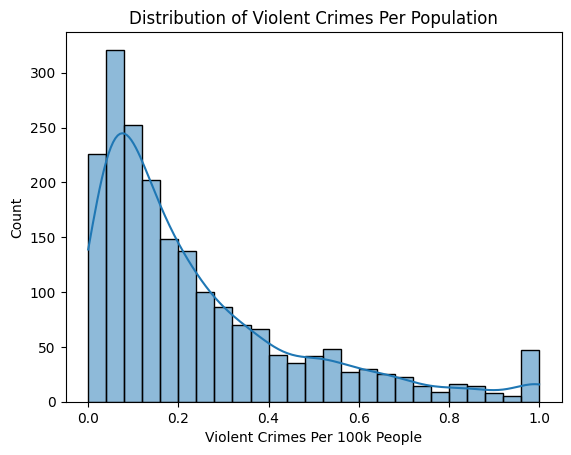

In [ ]:
# histogram of violent crime rate
sns.histplot(df['violentCrimesPerPop'], kde=True)
plt.title('Distribution of Violent Crimes Per Population')
plt.xlabel('Violent Crimes Per 100k People')
plt.show()

**Observation:** In this distribution of Violent Crimes Per Population in the United States, there are plenty more instances of low crime rate communities in comparison to high crime rate communities. The mean line reflects this as well. More specifically, the most frequent violent crimes per capita is between .0 and .1. It is also important to point out that cities with a high violent crime of 1.0 seem to have a spike of up to ~50 cities. Other than that the frequency starts to converge as the violent crime rate increases.

<ipython-input-10-0ea33e83e4d6>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


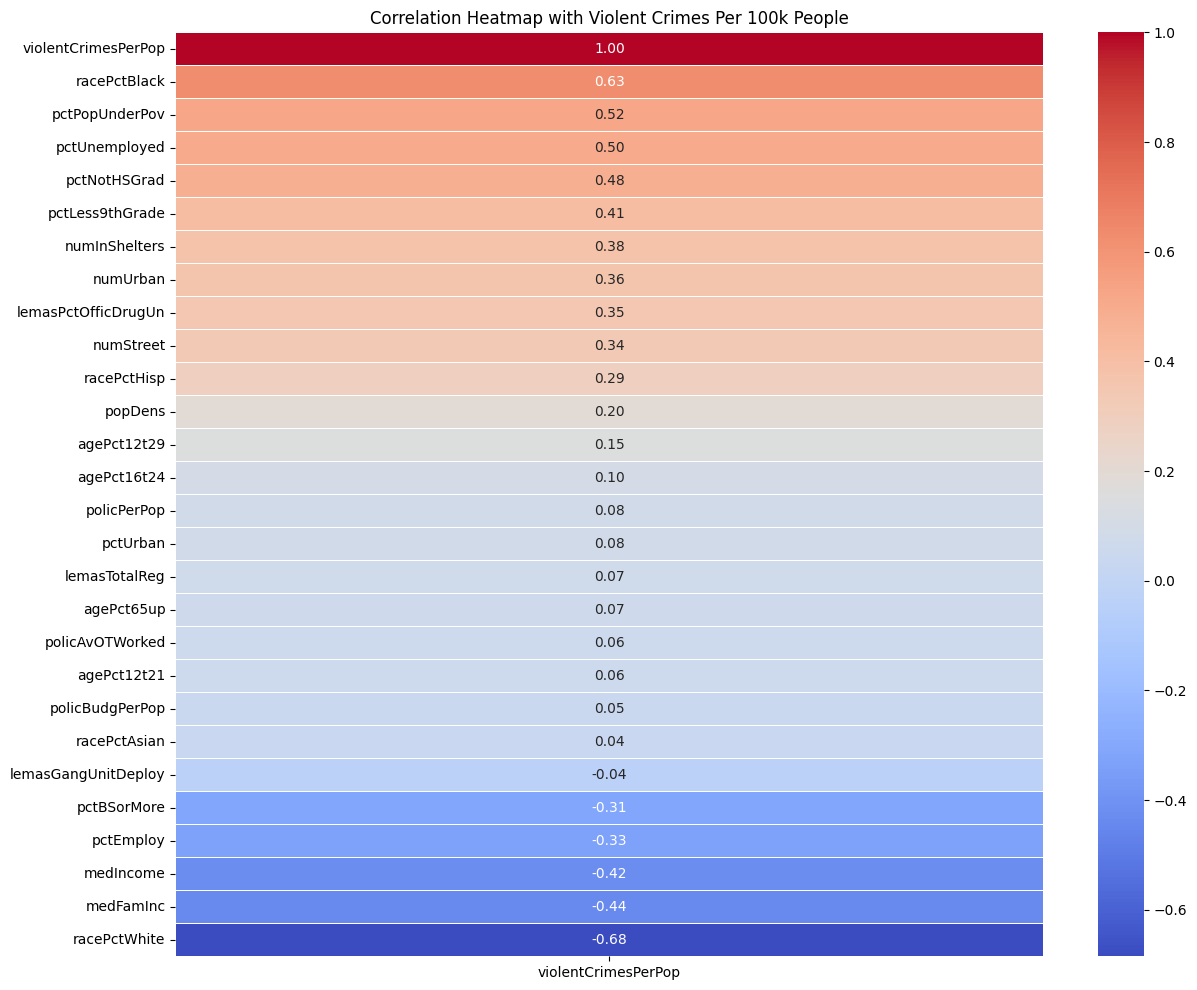

In [ ]:
# correlation heatmap against each variable
correlation_matrix = df.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix[['violentCrimesPerPop']].sort_values(by='violentCrimesPerPop', ascending=False), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap with Violent Crimes Per 100k People')
plt.show()

**Observation:** The correlation heatmap shows the correlation between a number of factors and violent crime rates. The factors include race, poverty, unemployment, education, income, and housing. The heatmap shows that there is a strong positive correlation between violent crime rates and race, poverty, unemployment, and the percentage of people who have not graduated from high school. There is also a moderate positive correlation between violent crime rates and the percentage of people who are renting their homes and the percentage of people who live in urban areas. There are a few possible explanations for this correlation. One possible explanation is that poverty, unemployment, and low educational attainment can lead to social exclusion and marginalization. Given the lack of resources in underserved communities, we can see that things like poverty, lack of education and opportunity for employment can contribute to a violent crime rate. Most of the communities statistically speaking are predominantly non-white, which indicates a high positive correlation between percentage of African American populace and violent crime rate. On the other hand with strong negative correlation, we have median income, employment, family median income, and percentage of white populace. Statistically speaking, when we look at cities with heavy affluence we can see that there are more thriving businesses, more opportunities for increasing median income, and there is also more of a caucasian predominance in these types of areas, which may lead to the strong negative correlation. In the middle we can see that the features that don’t have as much correlation are the age demographics and the police characteristics.

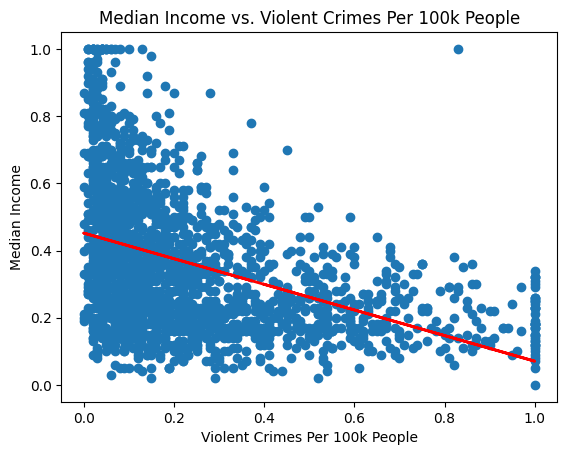

In [ ]:
# violent_Income = communities_df[['violentCrimesPerPop','medIncome']].dropna().astype(float)


# bins = [0, .10, .20, .30, .40, .50, .60, .70, .80, .90, 1]

# violent_Income['medIncome'] = pd.cut(violent_Income['violentCrimesPerPop'], bins=bins, right=True, labels=bins[:-1])
# sns.boxplot(x='violentCrimesPerPop', y='medIncome', data=violent_Income)
# plt.xlabel('Violent Crimes Per 100k People')
# plt.ylabel('Median Income')
# plt.title('Income Distribution by Violent Crimes Per 100k People')
# plt.show()
violent_Income = df[['violentCrimesPerPop', 'medIncome']].dropna().astype(float)

plt.scatter(violent_Income['violentCrimesPerPop'], violent_Income['medIncome'])

coeff, intercept = np.polyfit(violent_Income['violentCrimesPerPop'], violent_Income['medIncome'], 1)
line = coeff * violent_Income['medIncome'] + intercept
plt.plot(violent_Income['medIncome'], line, color='red', linewidth=2, label='Linear Regression')

plt.xlabel('Violent Crimes Per 100k People')
plt.ylabel('Median Income')
plt.title('Median Income vs. Violent Crimes Per 100k People')
plt.show()

**Observation:** This scatter plot of violent crimes per 100,000 people versus median income gives us an idea of these 2 features relate to one another. The red line is a negative correlation, which suggests that violent crimes are more likely to occur in areas with lower median income. This is consistent with the heat map that has shown that poverty is a strong predictor of violent crime. There are a number of possible explanations for this relationship. One possibility is that people in poverty are more likely to experience the stressors that can lead to crime, such as unemployment, lack of housing, and exposure to violence. Another possibility is that poverty undermines social cohesion and trust, which can create an environment where crime is more likely to flourish. It is important to note that correlation does not equal causation. Just because there is a relationship between poverty and violent crime does not mean that poverty causes violent crime. However, the research suggests that poverty does play a role in creating the conditions that lead to violent crime. The graph you sent also shows that there is a significant amount of variation in violent crime rates, even among areas with similar median incomes. This suggests that there are other factors, in addition to poverty, that contribute to violent crime. These factors may include:

*   The presence of gangs and other criminal organizations
*   The availability of guns
*   The quality of schools and other community institutions
*   The level of trust between the police and the community

The graph also shows that there are some areas with low median incomes that have relatively low violent crime rates. This suggests that it is possible to reduce violent crime rates in low-income areas, even if it is difficult to completely eliminate poverty.


In [ ]:
rich_dangerous_communities = communities_df[(communities_df['medIncome'] == 1) & (communities_df['violentCrimesPerPop'] > 0.5)]

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print(rich_dangerous_communities[['communityname', 'violentCrimesPerPop','racePctBlack','racePctWhite','racePctAsian','racePctHisp','agePct12t21','agePct12t29','agePct16t24','agePct65up','pctUrban','medIncome','medFamInc','pctPopUnderPov','pctLess9thGrade','pctNotHSGrad','pctBSorMore','pctEmploy','numInShelters','numStreet','lemasTotalReg','policPerPop','policAvOTWorked','popDens','policBudgPerPop','lemasPctOfficDrugUn','lemasGangUnitDeploy']])


              communityname  violentCrimesPerPop  racePctBlack  racePctWhite  \
375  LaCanadaFlintridgecity                 0.83          0.01          0.79   

     racePctAsian  racePctHisp  agePct12t21  agePct12t29  agePct16t24  \
375          0.76         0.08         0.39         0.29          0.2   

     agePct65up  pctUrban  medIncome  medFamInc  pctPopUnderPov  \
375        0.45       1.0        1.0        1.0            0.06   

     pctLess9thGrade  pctNotHSGrad  pctBSorMore  pctEmploy  numInShelters  \
375             0.06          0.05          0.9       0.53            0.0   

     numStreet lemasTotalReg policPerPop policAvOTWorked  popDens  \
375        0.0           NaN         NaN             NaN     0.02   

    policBudgPerPop  lemasPctOfficDrugUn lemasGangUnitDeploy  
375             NaN                  0.0                 NaN  


**Observation Cont.:** La Canada Flintridge has a violent crime rate of 0.83. It's demographic has a high percentage of Asians and Caucasians, which is strange since Caucasians have a strong negative correlation to our target variable. There are NAN values for all features pertaining to police, which may not help us further analyze why this community is an outlier.

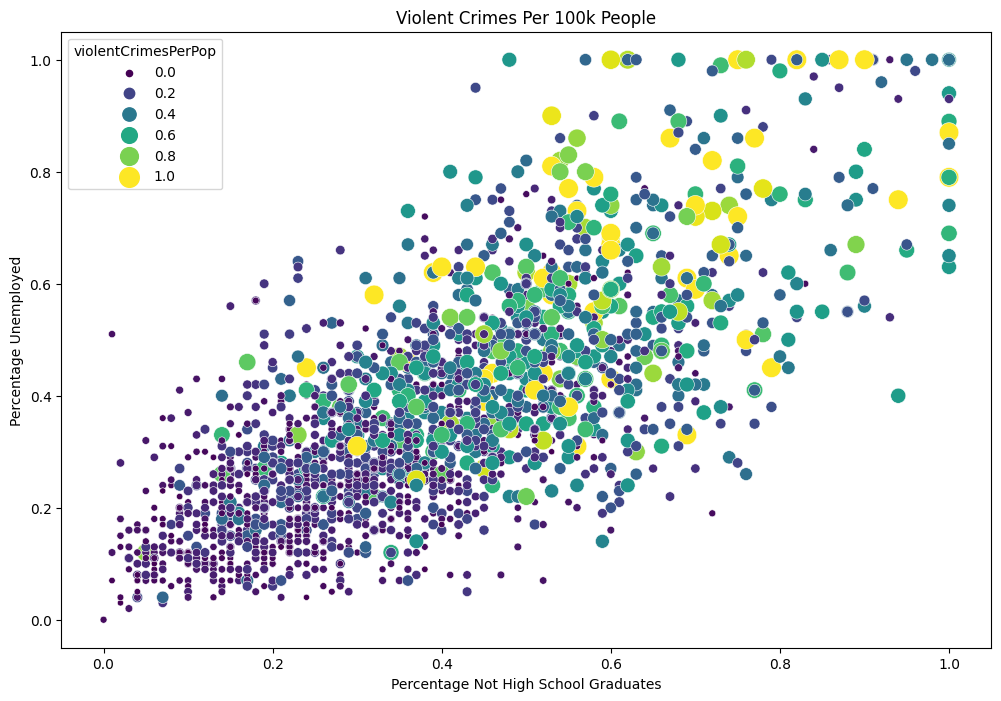

In [ ]:
plt.figure(figsize=(12, 8))

sns.scatterplot(x='pctNotHSGrad', y='pctUnemployed', hue='violentCrimesPerPop', size='violentCrimesPerPop', data=df, palette='viridis', sizes=(20, 200))

plt.xlabel('Percentage Not High School Graduates')
plt.ylabel('Percentage Unemployed')
plt.title('Relationship between High School Dropout, Unemployment, and Violent Crime Rates')

plt.title(label= 'Violent Crimes Per 100k People')

plt.show()

**Observation:** We used another scatter plot to show the relationship between the percent of people unemployed vs the percentage of people of non highschool graduates. The trend is a positive correlation, which suggests that violent crimes are more likely to occur in areas with a higher percentage of population with less than a high school diploma. Futhermore, there are more instances of 0, and .2 violent crime. rate near the bottom left of the graph. This implies that as more people are employed, and highschool graduates, the less violent crime there is. Near the middle of the graph there are more instances of crime rates that are .4 and above. To the right of the graph, most instances are equal to or above .6 in violent crime rate. This implies that as more people become unemployed, and don't graduate from highschool, violent crime increases. Overall, this data is a visual representation of the relationship between low educational attainment and violent crime. Additionally, it is a reminder that low educational attainment is a major problem that can have a significant impact on communities.

Axes(0.125,0.11;0.775x0.77)


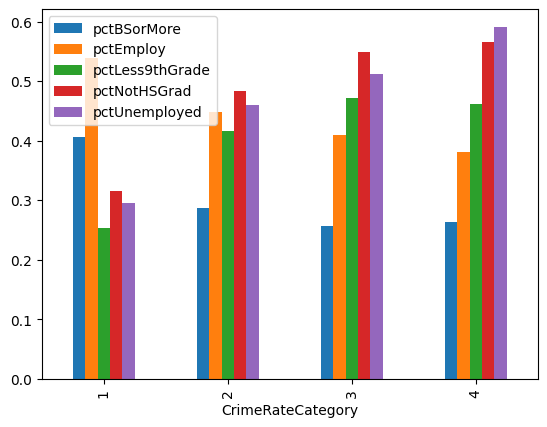

In [ ]:
print(pd.pivot_table(corr_df, values=['pctLess9thGrade','pctNotHSGrad','pctBSorMore', 'pctEmploy', 'pctUnemployed'], index='CrimeRateCategory', aggfunc='mean').plot.bar())

**Observation:** This graph shows that as with high crime rates, education seems to become less of a priority. The crime rate category of 1 has the highest average percentage of 16 and over employed while category 4 has the lowest. The average percentage of 25 and over with college degrees or higher also follows this pattern. The other 3 are the complete opposite. The average values of percentage of 16 and over that are unemployed, percentage of 25 and over with less than 9th grade education, and percentage of 25 and over without a high school diploma are the lowest in category 1, small crime rate, and the largest in category 4, large crime rate.

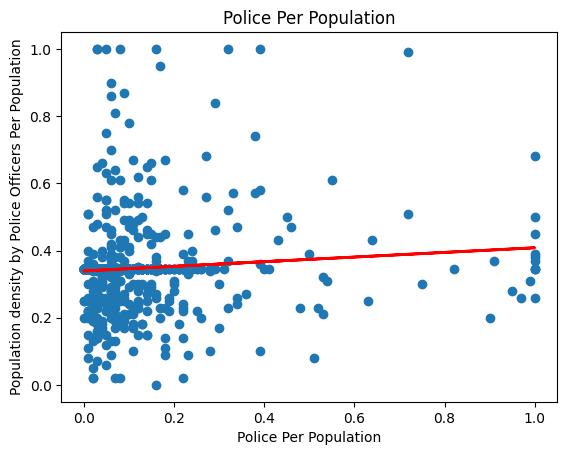

In [ ]:


# pop_df = df[['popDens','policPerPop']].astype(float)


# bins = [0, .10, .20, .30, .40, .50, .60, .70, .80, .90, 1]

# pop_df['popDens'] = pd.cut(pop_df['policPerPop'], bins=bins, right=True, labels=bins[:-1])

# sns.boxplot(x='popDens', y='policPerPop', data=pop_df)
# plt.xlabel('Population Density')
# plt.ylabel('Police Per Population')
# plt.title('Population density by Police Officers Per Population')
# plt.show()

pop_df = df[['popDens', 'policPerPop']].dropna().astype(float)

plt.scatter(pop_df['popDens'], pop_df['policPerPop'])

coeff, intercept = np.polyfit(pop_df['popDens'], pop_df['policPerPop'], 1)
line = coeff * pop_df['policPerPop'] + intercept
plt.plot(pop_df['policPerPop'], line, color='red', linewidth=2, label='Linear Regression')

plt.xlabel('Police Per Population')
plt.ylabel('Population density by Police Officers Per Population')
plt.title('Police Per Population')
plt.show()

**Observation:** In this graph, the data is highly concentrated around low police per population and population density. The highest, and lowest instances of population density are found when police per population is between 0, and .2. As the police per population increases, it does not seem that population consistently decreases or increases. What this graph implies is that the majority of communities have a police per population around .0 and .2. There seems to be no correlation between these variables.

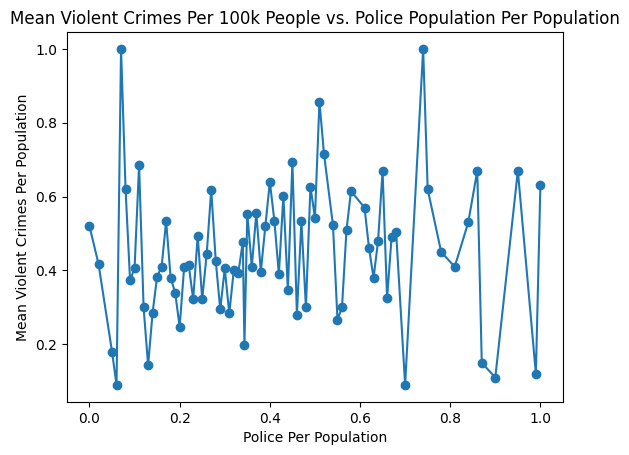

In [ ]:
# plt.(x='policPerPop', y='violentCrimesPerPop', data=df)
# plt.title('Police Officers Per Population vs Crime Rate')
# plt.show()
df.groupby('policPerPop')['violentCrimesPerPop'].mean().plot(kind='line', marker='o')

plt.title('Mean Violent Crimes Per 100k People vs. Police Population Per Population')
plt.xlabel('Police Per Population')
plt.ylabel('Mean Violent Crimes Per Population')
plt.show()

**Observation:** Even though it seems that a higher number of police values would mean lower crime rates, this graph shows that this is not necessarily the case. Even though we can see that there are instances of lower crime rates with higher numbers of police officers, there are plenty of instances otherwise. This makes sense if we remember that the number of police officers in an area is directly related to how dense the population is. The number of officers assigned to an area is most likely based on population size rather than crime rate. The data is scattered enough that we can't draw any sound conclusion of how these two values are related.

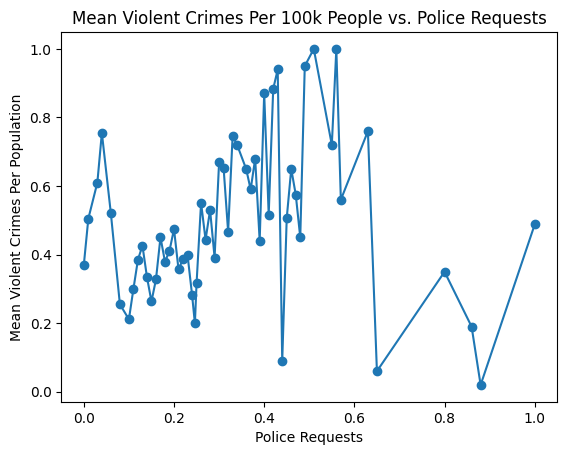

In [ ]:


df.groupby('lemasTotalReg')['violentCrimesPerPop'].mean().plot(kind='line', marker='o')

plt.title('Mean Violent Crimes Per 100k People vs. Police Requests')
plt.xlabel('Police Requests')
plt.ylabel('Mean Violent Crimes Per Population')
plt.show()

**Observation:** Similarly to the last graph this data is very scattered, and does not show a trend towards violent crime increasing, or decreasing as police requests increase. Despite this, it's worth noting that at higher police requests after .6, the average violent crime rate is low. We still can’t make any conclusion from this though.


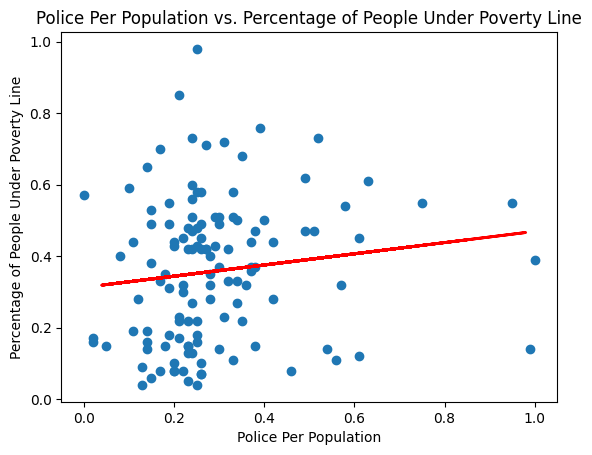

In [ ]:
new_df = communities_df.dropna()

pov_police = new_df[['policPerPop', 'pctPopUnderPov']].astype(float)
plt.scatter(pov_police['policPerPop'], pov_police['pctPopUnderPov'])

coeff, intercept = np.polyfit(pov_police['policPerPop'], pov_police['pctPopUnderPov'], 1)
line = coeff * pov_police['pctPopUnderPov'] + intercept
plt.plot(pov_police['pctPopUnderPov'], line, color='red', linewidth=2, label='Linear Regression')

plt.title('Police Per Population vs. Percentage of People Under Poverty Line')
plt.xlabel('Police Per Population')
plt.ylabel('Percentage of People Under Poverty Line')
plt.show()


**Observation:** There is a high concentration of the percentage of people under the poverty line between 0.1, and 0.6 when the police per population is between 0.1, and 0.3. As we go through the graph, there isn't a consistent trend. Even though the linear regression suggests it, there does not seem to be any correlation between police per population and the percentage of people under the poverty line.

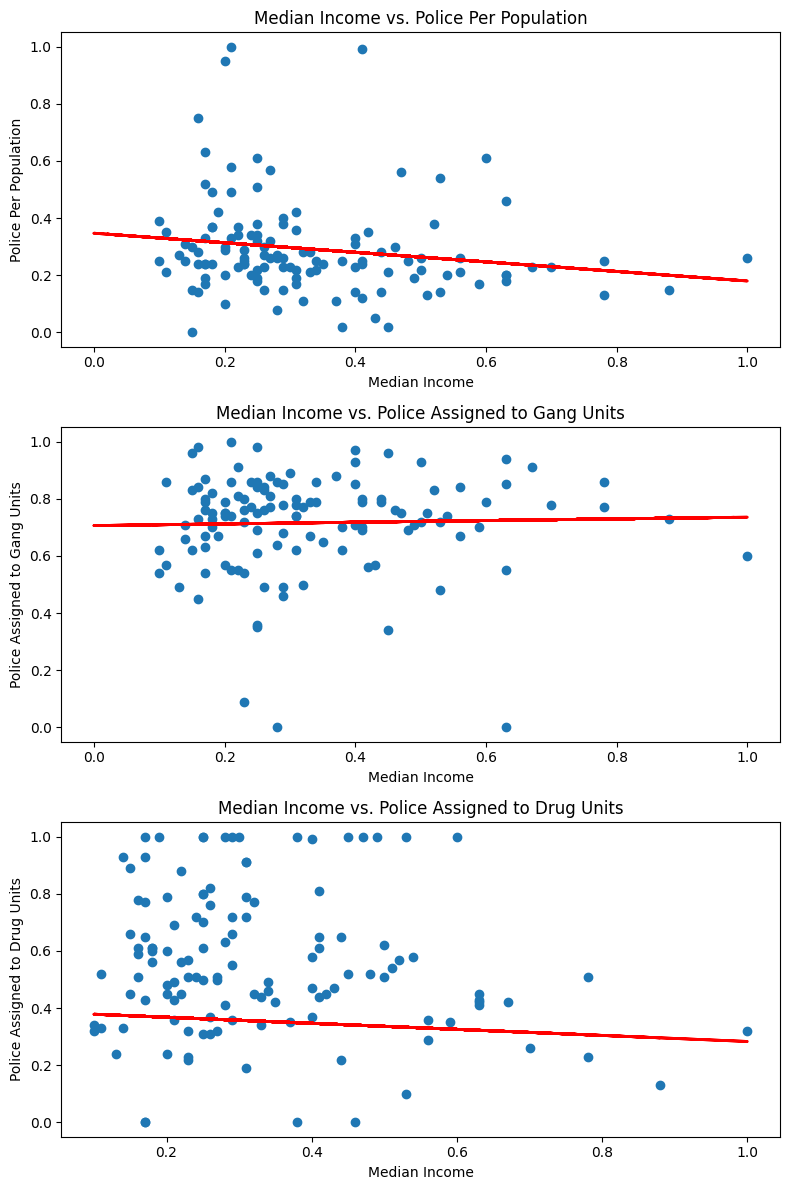

In [ ]:
policPop_Income = new_df[['medIncome', 'policPerPop']].astype(float)
gang_Income = new_df[['medIncome', 'lemasGangUnitDeploy']].astype(float)
drug_Income = new_df[['medIncome', 'lemasPctOfficDrugUn']].astype(float)

fig, axes = plt.subplots(3, 1, figsize=(8, 12))



axes[0].scatter(policPop_Income['medIncome'], policPop_Income['policPerPop'])
axes[0].set_title('Median Income vs. Police Per Population')
axes[0].set_xlabel('Median Income')
axes[0].set_ylabel('Police Per Population')

coeff, intercept = np.polyfit(policPop_Income['medIncome'], policPop_Income['policPerPop'], 1)
line = coeff * policPop_Income['policPerPop'] + intercept
axes[0].plot(policPop_Income['policPerPop'], line, color='red', linewidth=2, label='Linear Regression')


axes[1].scatter(gang_Income['medIncome'], gang_Income['lemasGangUnitDeploy'])
axes[1].set_title('Median Income vs. Police Assigned to Gang Units')
axes[1].set_xlabel('Median Income')
axes[1].set_ylabel('Police Assigned to Gang Units')

coeff, intercept = np.polyfit(gang_Income['medIncome'], gang_Income['lemasGangUnitDeploy'], 1)
line = coeff * gang_Income['lemasGangUnitDeploy'] + intercept
axes[1].plot(gang_Income['lemasGangUnitDeploy'], line, color='red', linewidth=2, label='Linear Regression')


axes[2].scatter(drug_Income['medIncome'], drug_Income['lemasPctOfficDrugUn'])
axes[2].set_title('Median Income vs. Police Assigned to Drug Units')
axes[2].set_xlabel('Median Income')
axes[2].set_ylabel('Police Assigned to Drug Units')

coeff, intercept = np.polyfit(drug_Income['lemasPctOfficDrugUn'], drug_Income['medIncome'], 1)
line = coeff * drug_Income['medIncome'] + intercept
axes[2].plot(drug_Income['medIncome'], line, color='red', linewidth=2, label='Linear Regression')


plt.tight_layout()
plt.show()

**Observation:** When comparing median income and police per population, the police per population is generally less than .4. However, there's an obvious negative trend. This implies that as median income increases, police per population decreases. This relationship could be caused by:
- An increase in population, leading to more people who have low incomes
- Smaller police populations in smaller cities that have higher levels of income




When comparing median income and police assigned to gang units, even though the regression line suggests it, they aren't correlated. Between the median incomes .1 and .4, the data is highly concentrated. As median income increases, the number of police assigned to gang units seems to stay around the same range.




When we compare median income and police assigned to drug units, we can see that there is actually a negative trend. Most instances are clustered between a median income of .1 and .3. Most of these instances have a police assigned to drug units value equal to or above .4. As median income increases, the instances generally go below this range. This could be due to
- Gangs being more prevalent in lower income communities due to them lacking support.


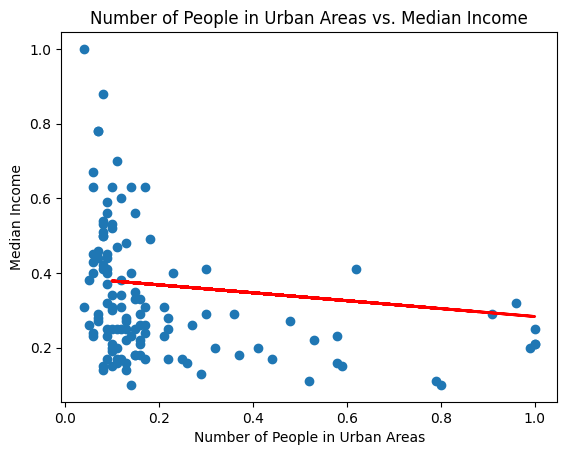

In [ ]:
medUrban = new_df[['numUrban','medIncome']].astype(float)
plt.scatter(medUrban['numUrban'], medUrban['medIncome'])

line = coeff * medUrban['medIncome'] + intercept
plt.plot(medUrban['medIncome'], line, color='red', linewidth=2, label='Linear Regression')

plt.title('Number of People in Urban Areas vs. Median Income')
plt.xlabel('Number of People in Urban Areas')
plt.ylabel('Median Income')
plt.show()

**Observation**: In this visualization, we want to see if there's a correlation between the number of people in urban areas and median income. The data is highly concentrated from 0 to .2 in the number of people in urban areas. In this range, we get our highest ranges of median income. As the number of people in urban places, we see median income decrease. This means that there could be a negative correlation between the number of people in urban areas and median income.


However, most communities in our data are considered urban, so the more likely reason for this correlation is tied to population density. Higher population density could lead to more varieties of income, some of which could be low.

Text(0.5, 0, 'Violent Crimes Per 100k People')

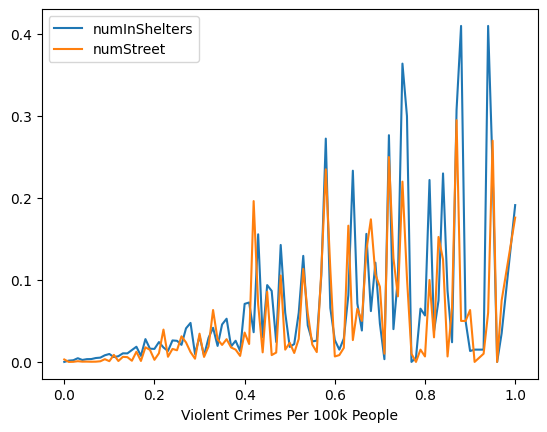

In [ ]:
# in shelters v criime rate

crime_shelter_street = corr_df[['numInShelters','numStreet','violentCrimesPerPop']]
crime_shelter_street = crime_shelter_street.groupby('violentCrimesPerPop')[['numInShelters','numStreet']].mean()
crime_shelter_street.plot()
plt.xlabel('Violent Crimes Per 100k People')

**Observation:** In this line graph we wanted to see if there was a correlation between homelessness and violent crime per 100k people. As we can see, the number of people in Shelter and on the streets have a similar line graph. This makes sense, since people who are homeless often alternate between living on the streets and in shelters. As we can see, as these variables increase, so do violent crimes per 100k people.

**Hypothesis #1 : There is a correlation socieeconomic factors and Violent crime**

In [ ]:
socioeconomic_crime = df[['medIncome', 'medFamInc', 'pctPopUnderPov','pctLess9thGrade','pctNotHSGrad','pctBSorMore','pctEmploy','numInShelters','numStreet', 'violentCrimesPerPop']]

In [ ]:
corrMatrix = socioeconomic_crime.corr()
corrWithCrime = corrMatrix['violentCrimesPerPop'].drop('violentCrimesPerPop')
print(corrWithCrime)

medIncome         -0.424221
medFamInc         -0.439108
pctPopUnderPov     0.521877
pctLess9thGrade    0.411096
pctNotHSGrad       0.483366
pctBSorMore       -0.314675
pctEmploy         -0.331643
numInShelters      0.375754
numStreet          0.340277
Name: violentCrimesPerPop, dtype: float64


**Analysis**: The number of violent crimes per 100K population increases as median houshold income, median family income, percentage of people 25 and over with a bachelors degree or higher education, and percentage of people 16 and over who are employed all decrease while percentage of people under the poverty level, percentage of people 25 and over with less than a 9th grade education, percentage of people 25 and over that are not high school graduates, number of people in homeless shelters, and number of homeless people counted in the street all increase.  

For each comparison, there is a graph that shows the correlation between each socioeconomic feature and crime and a chi square test that confirms the signficance of each correlation in terms of crime rate.

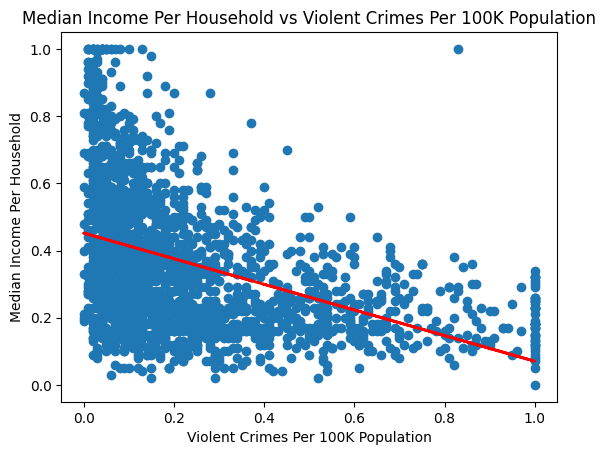

In [ ]:
#plotting the data
plt.scatter(socioeconomic_crime['violentCrimesPerPop'], socioeconomic_crime['medIncome'])
#making and plotting the best fit line
coeff, intercept = np.polyfit(socioeconomic_crime['violentCrimesPerPop'], socioeconomic_crime['medIncome'], 1)
line = coeff * socioeconomic_crime['medIncome'] + intercept
plt.plot(socioeconomic_crime['medIncome'], line, color='red', linewidth=2, label='Linear Regression')

plt.title('Median Income Per Household vs Violent Crimes Per 100K Population')
plt.ylabel("Median Income Per Household")
plt.xlabel('Violent Crimes Per 100K Population')
plt.show()

**Analysis:  Based on this graph as crime rate increases, the median income decreases which matches up with its negative regression coefficient.**

**Null Hypothesis: There is no correlation between the median income per household and crime rate.**

**Alternative hypothesis: There is a negative correlation between the median income per household and crime rate.**

In [ ]:
crosstab = pd.crosstab(socioeconomic_crime['medIncome'], socioeconomic_crime['violentCrimesPerPop'])
chi2, p, dof, expected = chi2_contingency(crosstab)
print("chi square:", chi2)
print("p-value:", p)
print("expected: ", expected)
print("critical value:", scipy.stats.chi2.ppf(.95, dof))

chi square: 7600.418107728905
p-value: 1.0
expected:  [[5.01504514e-03 1.90571715e-02 3.71113340e-02 ... 5.01504514e-04
  1.00300903e-03 2.20661986e-02]
 [1.50451354e-02 5.71715145e-02 1.11334002e-01 ... 1.50451354e-03
  3.00902708e-03 6.61985958e-02]
 [5.01504514e-03 1.90571715e-02 3.71113340e-02 ... 5.01504514e-04
  1.00300903e-03 2.20661986e-02]
 ...
 [5.01504514e-03 1.90571715e-02 3.71113340e-02 ... 5.01504514e-04
  1.00300903e-03 2.20661986e-02]
 [5.01504514e-03 1.90571715e-02 3.71113340e-02 ... 5.01504514e-04
  1.00300903e-03 2.20661986e-02]
 [1.40421264e-01 5.33600802e-01 1.03911735e+00 ... 1.40421264e-02
  2.80842528e-02 6.17853561e-01]]
critical value: 9733.930336604648


**Conclusion**: Since p-value is greater than the significance level of .05 meaning this finding isn't significant. Because the chi squared statistic is less than our critical value there is no correlation. We can actually accept of the null hypothesis.

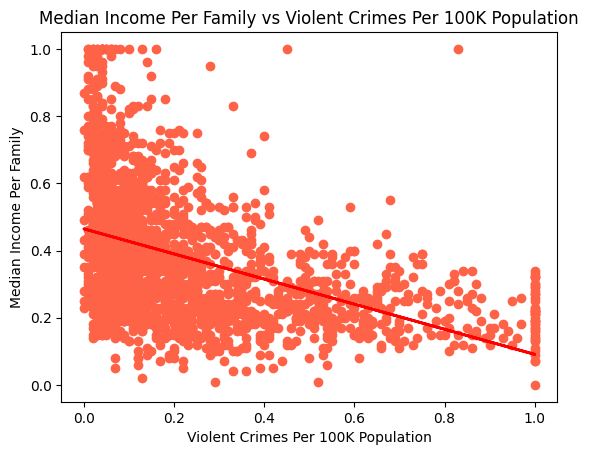

In [ ]:
#plotting the data
plt.scatter(socioeconomic_crime['violentCrimesPerPop'], socioeconomic_crime['medFamInc'], c='tomato')
#making and plotting the best fit line
coeff, intercept = np.polyfit(socioeconomic_crime['violentCrimesPerPop'], socioeconomic_crime['medFamInc'], 1)
line = coeff * socioeconomic_crime['medFamInc'] + intercept
plt.plot(socioeconomic_crime['medFamInc'], line, color='red', linewidth=2, label='Linear Regression')

plt.title('Median Income Per Family vs Violent Crimes Per 100K Population')
plt.ylabel("Median Income Per Family")
plt.xlabel('Violent Crimes Per 100K Population')
plt.show()

**Analysis: Similar to the last graph, the median income per family also decreases as crime increases. The graph is very similar to the last one which is also backed up by the very close values for coefficients.**

**Null Hypothesis: There is no correlation between the median income per family and crime rate.**

**Alternative hypothesis: There is a negative correlation between the median income per family and crime rate.**

In [ ]:
crosstab = pd.crosstab(socioeconomic_crime['medFamInc'], socioeconomic_crime['violentCrimesPerPop'])
chi2, p, dof, expected = chi2_contingency(crosstab)
print("chi square:", chi2)
print("p-value:", p)
print("expected: ", expected)
print("critical value:", scipy.stats.chi2.ppf(.95, dof))

chi square: 7685.607063221532
p-value: 1.0
expected:  [[5.01504514e-03 1.90571715e-02 3.71113340e-02 ... 5.01504514e-04
  1.00300903e-03 2.20661986e-02]
 [1.00300903e-02 3.81143430e-02 7.42226680e-02 ... 1.00300903e-03
  2.00601805e-03 4.41323972e-02]
 [5.01504514e-03 1.90571715e-02 3.71113340e-02 ... 5.01504514e-04
  1.00300903e-03 2.20661986e-02]
 ...
 [1.50451354e-02 5.71715145e-02 1.11334002e-01 ... 1.50451354e-03
  3.00902708e-03 6.61985958e-02]
 [3.00902708e-02 1.14343029e-01 2.22668004e-01 ... 3.00902708e-03
  6.01805416e-03 1.32397192e-01]
 [1.30391174e-01 4.95486459e-01 9.64894684e-01 ... 1.30391174e-02
  2.60782347e-02 5.73721163e-01]]
critical value: 9635.770202347336


**Conclusion**: Similar to the last chi squared test, the chi squared statistic is below the critical value thus thre is no correlation.

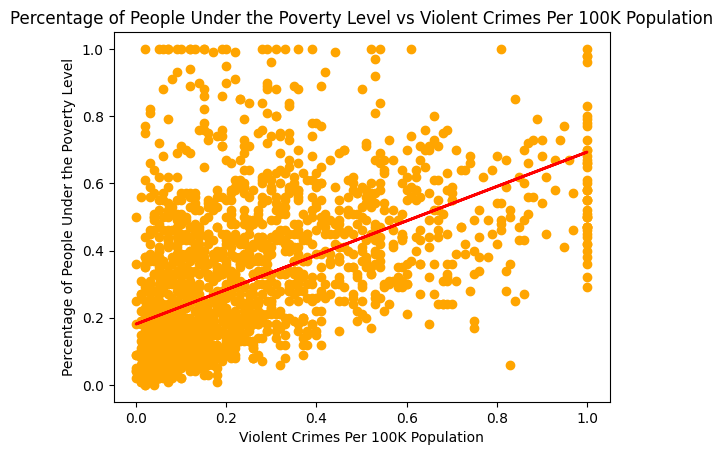

In [ ]:
#plotting the data
plt.scatter(socioeconomic_crime['violentCrimesPerPop'], socioeconomic_crime['pctPopUnderPov'], c='orange')
#making and plotting the best fit line
coeff, intercept = np.polyfit(socioeconomic_crime['violentCrimesPerPop'], socioeconomic_crime['pctPopUnderPov'], 1)
line = coeff * socioeconomic_crime['pctPopUnderPov'] + intercept
plt.plot(socioeconomic_crime['pctPopUnderPov'], line, color='red', linewidth=2, label='Linear Regression')

plt.title('Percentage of People Under the Poverty Level vs Violent Crimes Per 100K Population')
plt.ylabel("Percentage of People Under the Poverty Level")
plt.xlabel('Violent Crimes Per 100K Population')

plt.show()

**Analysis: This graph shows that as crime rate increases, the percentage of people under the poverty level also increases. This makes sense if we consider the idea that a city with high crime rate might have a lot of people in poverty. The cities most likely aren't safe nor are they the best place to stay. The positive regression coefficient confirms this theory.**

**Null hypothesis: There is no correlation between the percentage of people under the poverty level and crime rate.**

**Alternative hypothesis: There is a positive correlation between the percentage of people under the poverty level and crime rate.**

In [ ]:
crosstab = pd.crosstab(socioeconomic_crime['pctPopUnderPov'], socioeconomic_crime['violentCrimesPerPop'])
chi2, p, dof, expected = chi2_contingency(crosstab)
print("chi square:", chi2)
print("p-value:", p)
print("expected: ", expected)
print("critical value:", scipy.stats.chi2.ppf(.95, dof))

chi square: 13675.769178365335
p-value: 9.703855597430451e-150
expected:  [[0.01504514 0.05717151 0.111334   ... 0.00150451 0.00300903 0.0661986 ]
 [0.04513541 0.17151454 0.33400201 ... 0.00451354 0.00902708 0.19859579]
 [0.12036108 0.45737212 0.89067202 ... 0.01203611 0.02407222 0.52958877]
 ...
 [0.01003009 0.03811434 0.07422267 ... 0.00100301 0.00200602 0.0441324 ]
 [0.01504514 0.05717151 0.111334   ... 0.00150451 0.00300903 0.0661986 ]
 [0.12537613 0.47642929 0.92778335 ... 0.01253761 0.02507523 0.55165496]]
critical value: 9832.08456645825


**Conclusion**: The chi squared statistic is greater than the critical value, thus there is a correlation. Since the p-value is less than 0.05, the data is statistically significant. We reject the null hypothesis and accept the alternative: there is a positive correlation between percentage of people under the poverty level and crime rate.

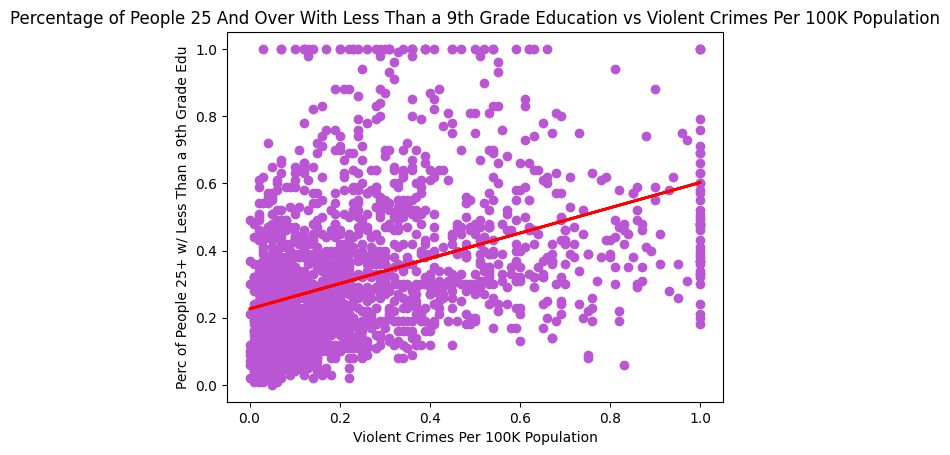

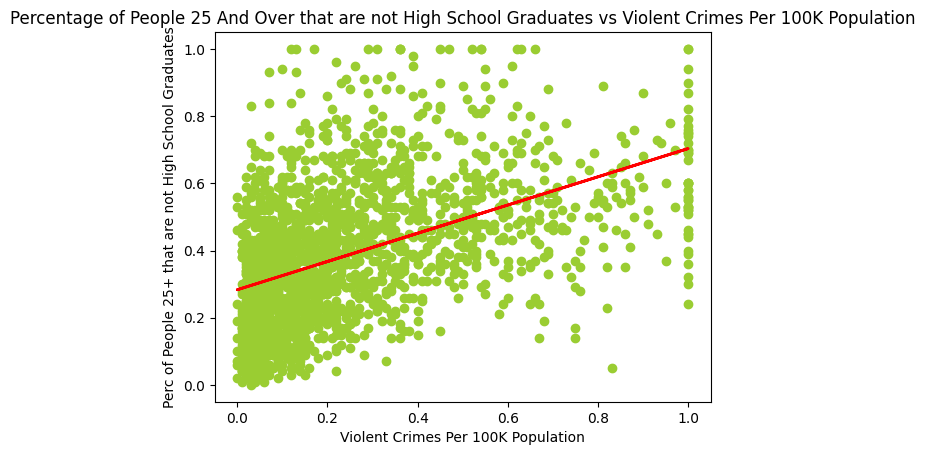

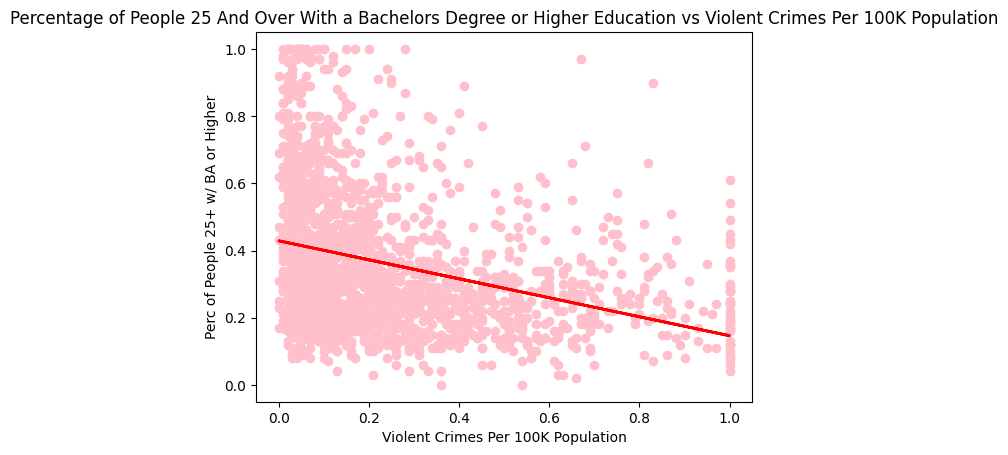

In [ ]:
#plotting the data
plt.scatter(socioeconomic_crime['violentCrimesPerPop'], socioeconomic_crime['pctLess9thGrade'], c='mediumorchid')
#making and plotting the best fit line
coeff, intercept = np.polyfit(socioeconomic_crime['violentCrimesPerPop'], socioeconomic_crime['pctLess9thGrade'], 1)
line = coeff * socioeconomic_crime['pctLess9thGrade'] + intercept
plt.plot(socioeconomic_crime['pctLess9thGrade'], line, color='red', linewidth=2, label='Linear Regression')

plt.title('Percentage of People 25 And Over With Less Than a 9th Grade Education vs Violent Crimes Per 100K Population')
plt.ylabel("Perc of People 25+ w/ Less Than a 9th Grade Edu")
plt.xlabel('Violent Crimes Per 100K Population')
plt.show()

#plotting the data
plt.scatter(socioeconomic_crime['violentCrimesPerPop'], socioeconomic_crime['pctNotHSGrad'], c='yellowgreen')
#making and plotting the best fit line
coeff, intercept = np.polyfit(socioeconomic_crime['violentCrimesPerPop'], socioeconomic_crime['pctNotHSGrad'], 1)
line = coeff * socioeconomic_crime['pctNotHSGrad'] + intercept
plt.plot(socioeconomic_crime['pctNotHSGrad'], line, color='red', linewidth=2, label='Linear Regression')

plt.title('Percentage of People 25 And Over that are not High School Graduates vs Violent Crimes Per 100K Population')
plt.ylabel("Perc of People 25+ that are not High School Graduates")
plt.xlabel('Violent Crimes Per 100K Population')
plt.show()

#plotting the data
plt.scatter(socioeconomic_crime['violentCrimesPerPop'], socioeconomic_crime['pctBSorMore'], c='pink')
#making and plotting the best fit line
coeff, intercept = np.polyfit(socioeconomic_crime['violentCrimesPerPop'], socioeconomic_crime['pctBSorMore'], 1)
line = coeff * socioeconomic_crime['pctBSorMore'] + intercept
plt.plot(socioeconomic_crime['pctBSorMore'], line, color='red', linewidth=2, label='Linear Regression')

plt.title('Percentage of People 25 And Over With a Bachelors Degree or Higher Education vs Violent Crimes Per 100K Population')
plt.ylabel("Perc of People 25+ w/ BA or Higher")
plt.xlabel('Violent Crimes Per 100K Population')
plt.show()

**Analysis: These graphs show that there is a correlation between crime rate and education in a city. In places with higher crime rates, there are more uneducated people and less people with degrees or highschool diplomas. Those cities most likely don't have a good education system. However, one thing we can't say for certain is which was the cause and which was the affect. All we can say that it really looks like there are positive correlations between people who didn't go to highschool or graduate from one and crime rates and a negative correlation between people with degrees and crime rate. When crime rate is high, education seems to longer be a major priority or concern.**

**Null hypothesis: There is no correlation between the percentage of people 25+ with less than 9th grade education, percentage of people 25+ who didn't graduate high school, and percentage of 25+ with a college degree or higher with crime rate.**

**Alternative hypothesis: There is a positive correlation between the percentage of people 25+ with less than 9th grade education and percentage of people 25+ who didn't graduate high school with crime rate. There is a negative correlation between percentage of 25+ with a college degree or higher with crime rate.**  

In [ ]:
crosstab = pd.crosstab(socioeconomic_crime['violentCrimesPerPop'], socioeconomic_crime['pctLess9thGrade'])
chi2, p, dof, expected = chi2_contingency(crosstab)
print("chi square:", chi2)
print("p-value:", p)
print("expected: ", expected)
print("critical value:", scipy.stats.chi2.ppf(.95, dof), '\n\n')


crosstab = pd.crosstab(socioeconomic_crime['violentCrimesPerPop'], socioeconomic_crime['pctNotHSGrad'])
chi2, p, dof, expected = chi2_contingency(crosstab)
print("chi square:", chi2)
print("p-value:", p)
print("expected: ", expected)
print("critical value:", scipy.stats.chi2.ppf(.95, dof), '\n\n')

crosstab = pd.crosstab(socioeconomic_crime['violentCrimesPerPop'], socioeconomic_crime['pctBSorMore'])
chi2, p, dof, expected = chi2_contingency(crosstab)
print("chi square:", chi2)
print("p-value:", p)
print("expected: ", expected)
print("critical value:", scipy.stats.chi2.ppf(.95, dof), '\n\n')

chi square: 12631.121720923511
p-value: 8.420264131392984e-107
expected:  [[5.01504514e-03 2.00601805e-02 5.01504514e-02 ... 2.00601805e-02
  5.01504514e-03 2.25677031e-01]
 [1.90571715e-02 7.62286861e-02 1.90571715e-01 ... 7.62286861e-02
  1.90571715e-02 8.57572718e-01]
 [3.71113340e-02 1.48445336e-01 3.71113340e-01 ... 1.48445336e-01
  3.71113340e-02 1.67001003e+00]
 ...
 [5.01504514e-04 2.00601805e-03 5.01504514e-03 ... 2.00601805e-03
  5.01504514e-04 2.25677031e-02]
 [1.00300903e-03 4.01203611e-03 1.00300903e-02 ... 4.01203611e-03
  1.00300903e-03 4.51354062e-02]
 [2.20661986e-02 8.82647944e-02 2.20661986e-01 ... 8.82647944e-02
  2.20661986e-02 9.92978937e-01]]
critical value: 9537.604072137445 


chi square: 11392.597807486858
p-value: 3.1398105563698506e-38
expected:  [[5.01504514e-03 1.50451354e-02 3.00902708e-02 ... 5.01504514e-03
  5.01504514e-03 9.02708124e-02]
 [1.90571715e-02 5.71715145e-02 1.14343029e-01 ... 1.90571715e-02
  1.90571715e-02 3.43029087e-01]
 [3.71113340e-02 

***Conclusion***: In the first two tests, the results have correlations, because the chi squared statistic is greater than the critical value. We can reject the null, and since p-values are less than 0.05, the data is statistically significant. Meaning that the percentage of people 25+ with less than 9th grade education and percentage of people 25+ who didn't graduate high school have a positive correlation with crime rate. In the last test however, the chi squared statistic is less than the critical value so the results are not statistically significant.

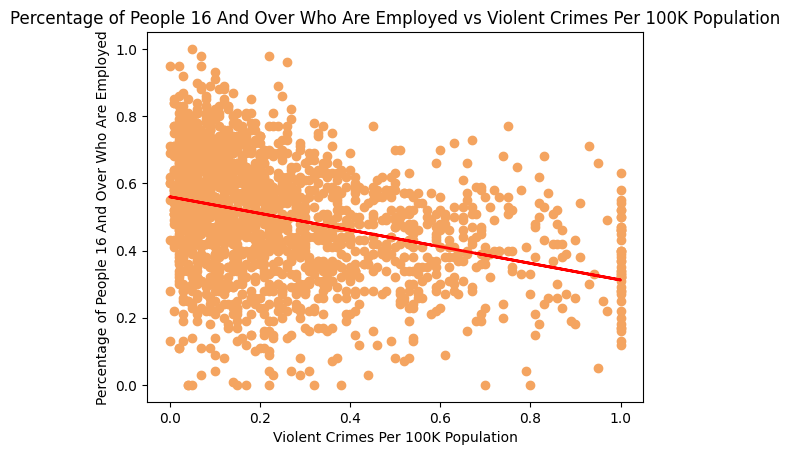

In [ ]:
#plotting the data
plt.scatter(socioeconomic_crime['violentCrimesPerPop'], socioeconomic_crime['pctEmploy'], c='sandyBrown')
#making and plotting the best fit line
coeff, intercept = np.polyfit(socioeconomic_crime['violentCrimesPerPop'], socioeconomic_crime['pctEmploy'], 1)
line = coeff * socioeconomic_crime['pctEmploy'] + intercept
plt.plot(socioeconomic_crime['pctEmploy'], line, color='red', linewidth=2, label='Linear Regression')

plt.title('Percentage of People 16 And Over Who Are Employed vs Violent Crimes Per 100K Population')
plt.ylabel("Percentage of People 16 And Over Who Are Employed")
plt.xlabel('Violent Crimes Per 100K Population')
plt.show()

**Analysis: Based on this graph and the best fit line, there is a negative correlation between crime rate and percentage of people 16+ who are employed.**

**Null hypothesis: There is no correlation between the percentage of people 16+ who are employed and crime rate.**

**Alternative hypothesis: There is a negative correlation between the percentage of people 16+ who are employed and crime rate.**

In [ ]:
crosstab = pd.crosstab(socioeconomic_crime['pctEmploy'], socioeconomic_crime['violentCrimesPerPop'])
chi2, p, dof, expected = chi2_contingency(crosstab)
print("chi square:", chi2)
print("p-value:", p)
print("expected: ", expected)
print("critical value:", scipy.stats.chi2.ppf(.95, dof))

chi square: 10078.582223549703
p-value: 3.254357840157287e-10
expected:  [[0.05015045 0.19057172 0.37111334 ... 0.00501505 0.01003009 0.22066199]
 [0.00501505 0.01905717 0.03711133 ... 0.0005015  0.00100301 0.0220662 ]
 [0.02006018 0.07622869 0.14844534 ... 0.00200602 0.00401204 0.08826479]
 ...
 [0.00501505 0.01905717 0.03711133 ... 0.0005015  0.00100301 0.0220662 ]
 [0.01003009 0.03811434 0.07422267 ... 0.00100301 0.00200602 0.0441324 ]
 [0.00501505 0.01905717 0.03711133 ... 0.0005015  0.00100301 0.0220662 ]]
critical value: 9439.431852035552


***Conclusion***: The results are statistically significant because the p-value is less than 0.05. The chi squared statistic is greater than the critical value, thus we reject the null hypothesis and accept the alternative. This means that there is a negative correlation between the percentage of people 16+ who are employed and crime rate.

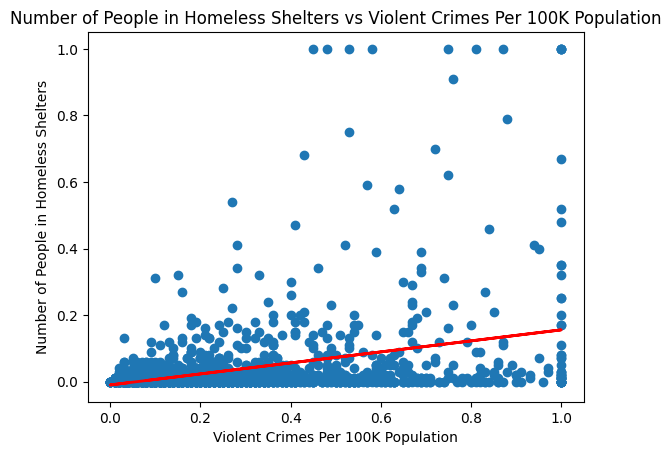

In [ ]:
#plotting the data
plt.scatter(socioeconomic_crime['violentCrimesPerPop'], socioeconomic_crime['numInShelters'])
#making and plotting the best fit line
coeff, intercept = np.polyfit(socioeconomic_crime['violentCrimesPerPop'], socioeconomic_crime['numInShelters'], 1)
line = coeff * socioeconomic_crime['numInShelters'] + intercept
plt.plot(socioeconomic_crime['numInShelters'], line, color='red', linewidth=2, label='Linear Regression')

plt.title('Number of People in Homeless Shelters vs Violent Crimes Per 100K Population')
plt.ylabel("Number of People in Homeless Shelters")
plt.xlabel('Violent Crimes Per 100K Population')
plt.show()

***Analysis*: Based on this visual, it seems like there is a positive correlation between the number of people in homeless shelters and crime rate.**

**Null hypothesis: There is no correlation between the number of people in homeless shelters and crime rate.**

**Alternative hypothesis: There is a positive correlation between the number of people in homeless shelters and crime rate.**

In [ ]:
crosstab = pd.crosstab(socioeconomic_crime['numInShelters'], socioeconomic_crime['violentCrimesPerPop'])
chi2, p, dof, expected = chi2_contingency(crosstab)
print("chi square:", chi2)
print("p-value:", p)
print("expected: ", expected)
print("critical value:", scipy.stats.chi2.ppf(.95, dof))

chi square: 14028.522685878566
p-value: 0.0
expected:  [[6.31895687e+00 2.40120361e+01 4.67602808e+01 ... 6.31895687e-01
  1.26379137e+00 2.78034102e+01]
 [1.24373119e+00 4.72617854e+00 9.20361083e+00 ... 1.24373119e-01
  2.48746239e-01 5.47241725e+00]
 [4.51354062e-01 1.71514544e+00 3.34002006e+00 ... 4.51354062e-02
  9.02708124e-02 1.98595787e+00]
 ...
 [5.01504514e-03 1.90571715e-02 3.71113340e-02 ... 5.01504514e-04
  1.00300903e-03 2.20661986e-02]
 [5.01504514e-03 1.90571715e-02 3.71113340e-02 ... 5.01504514e-04
  1.00300903e-03 2.20661986e-02]
 [5.51654965e-02 2.09628887e-01 4.08224674e-01 ... 5.51654965e-03
  1.10330993e-02 2.42728185e-01]]
critical value: 5308.91774722617


***Conclusion***: The results are statistically significant since p-value is close to or equal to 0, and since the chi square statistic is greater than the critical value, we can conclude there is a positive correlation.

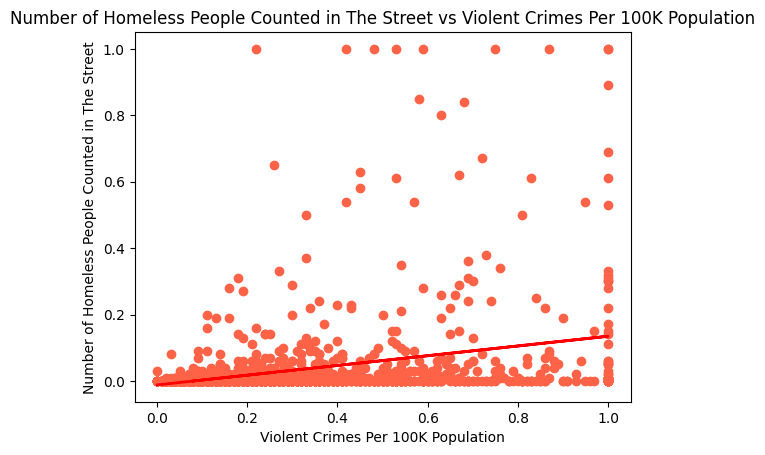

In [ ]:
#plotting the data
plt.scatter(socioeconomic_crime['violentCrimesPerPop'], socioeconomic_crime['numStreet'], c='tomato')
#making and plotting the best fit line
coeff, intercept = np.polyfit(socioeconomic_crime['violentCrimesPerPop'], socioeconomic_crime['numStreet'], 1)
line = coeff * socioeconomic_crime['numStreet'] + intercept
plt.plot(socioeconomic_crime['numStreet'], line, color='red', linewidth=2, label='Linear Regression')

plt.title('Number of Homeless People Counted in The Street vs Violent Crimes Per 100K Population')
plt.ylabel("Number of Homeless People Counted in The Street")
plt.xlabel('Violent Crimes Per 100K Population')
plt.show()

***Analysis*: Even though there is a lot of noise, based on the best fit line the graph shows a positive correlation.**

**Null hypothesis: There is no correlation between the number of homeless people in the streets and crime rate.**

**Alternative hypothesis: There is a correlation between the number of homeless people in the streets and crime rate.**

In [ ]:
crosstab = pd.crosstab(socioeconomic_crime['numStreet'], socioeconomic_crime['violentCrimesPerPop'])
chi2, p, dof, expected = chi2_contingency(crosstab)
print("chi square:", chi2)
print("p-value:", p)
print("expected: ", expected)
print("critical value:", scipy.stats.chi2.ppf(.95, dof))

chi square: 11706.978688017465
p-value: 0.0
expected:  [[8.00902708e+00 3.04343029e+01 5.92668004e+01 ... 8.00902708e-01
  1.60180542e+00 3.52397192e+01]
 [5.26579739e-01 2.00100301e+00 3.89669007e+00 ... 5.26579739e-02
  1.05315948e-01 2.31695085e+00]
 [2.70812437e-01 1.02908726e+00 2.00401204e+00 ... 2.70812437e-02
  5.41624875e-02 1.19157472e+00]
 ...
 [5.01504514e-03 1.90571715e-02 3.71113340e-02 ... 5.01504514e-04
  1.00300903e-03 2.20661986e-02]
 [5.01504514e-03 1.90571715e-02 3.71113340e-02 ... 5.01504514e-04
  1.00300903e-03 2.20661986e-02]
 [4.51354062e-02 1.71514544e-01 3.34002006e-01 ... 4.51354062e-03
  9.02708124e-03 1.98595787e-01]]
critical value: 5210.336703540159


***Conclusion***: The results are statistically significant since the p-value is close to or less than 0, and the chi square value is more than the critical value, meaning we can reject the null hypothesis.

In [ ]:
socioeconomic = ['medIncome', 'medFamInc', 'pctPopUnderPov','pctLess9thGrade','pctNotHSGrad','pctBSorMore','pctEmploy','numInShelters','numStreet']

for var in socioeconomic:
    correlation_coefficient, p_value = pearsonr(socioeconomic_crime['violentCrimesPerPop'], df[var])

print("Total correlation:", correlation_coefficient)
print("Total P-Value:", p_value)

Total correlation: 0.34027679939936656
Total P-Value: 3.08171913457784e-55


**Conclusion**: Based on all of these tests, not all of these socioeconomic features are statistically relevant for our regression analysis. The median income per household, median income per family, and the percentage of people 25 and over that have a bachelor's degree or higher have no correlation with violent crime per population. The rest have significance, and a correlation: number of homeless in shelters the number of homeless on the streets, the percentage of people under the poverty level, the percentage of people 25 and over with less than 9th grade education, and the percentage of people 25 and over who didn't graduate high school all have a positive correlation with crime rate. The percentage of people 16 and over who are employed is negatively correlated with crime rate.

Overall, since the total p-value is under 0.05 we conclude that there is a positive correlation between socioeconomic features and crime rate.



**Hypothesis #2**

**Null hypothesis**: There is no correlation between the demographic of a community and crime rate.

**Alternative hypothesis**: There is a correlation between the demographic of a community and crime rate.

In [ ]:
# subsetting demographic and violentcrimesperpop
demographic_crime = corr_df[['racePctBlack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'violentCrimesPerPop']]

We begin with a visualization of violent crimes per population to each race. By adding a linear regression line, we can better observe the overall trend in each scatter plot.

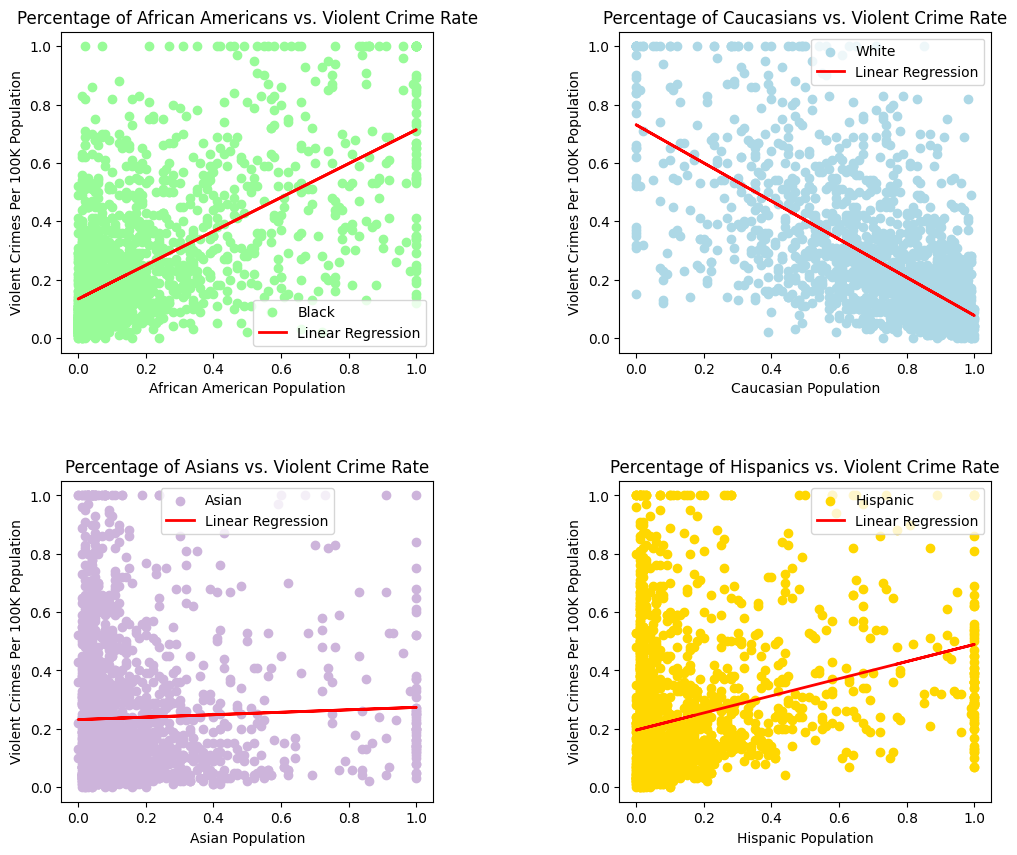

In [ ]:
# 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# scatter plot for African American
slope_black, intercept_black = np.polyfit(demographic_crime['racePctBlack'], demographic_crime['violentCrimesPerPop'], 1)
trendline_black = slope_black * demographic_crime['racePctBlack'] + intercept_black
axs[0, 0].scatter(demographic_crime['racePctBlack'], demographic_crime['violentCrimesPerPop'], c='#98FB98', label='Black')
axs[0, 0].plot(demographic_crime['racePctBlack'], trendline_black, color='red', linewidth=2, label='Linear Regression')
axs[0, 0].set_title('Percentage of African Americans vs. Violent Crime Rate')
axs[0, 0].set(xlabel='African American Population')
axs[0, 0].set(ylabel='Violent Crimes Per 100K Population')

# scatter plot for Caucasian
slope_white, intercept_white = np.polyfit(demographic_crime['racePctWhite'], demographic_crime['violentCrimesPerPop'], 1)
trendline_white = slope_white * demographic_crime['racePctWhite'] + intercept_white
axs[0, 1].scatter(demographic_crime['racePctWhite'], demographic_crime['violentCrimesPerPop'], c='lightblue', label='White')
axs[0, 1].plot(demographic_crime['racePctWhite'], trendline_white, color='red', linewidth=2, label='Linear Regression')
axs[0, 1].set_title('Percentage of Caucasians vs. Violent Crime Rate')
axs[0, 1].set(xlabel='Caucasian Population')
axs[0, 1].set(ylabel='Violent Crimes Per 100K Population')

# scatter plot for Asian
slope_asian, intercept_asian = np.polyfit(demographic_crime['racePctAsian'], demographic_crime['violentCrimesPerPop'], 1)
trendline_asian = slope_asian * demographic_crime['racePctAsian'] + intercept_asian
axs[1, 0].scatter(demographic_crime['racePctAsian'], demographic_crime['violentCrimesPerPop'], c='#CDB4DB', label='Asian')
axs[1, 0].plot(demographic_crime['racePctAsian'], trendline_asian, color='red', linewidth=2, label='Linear Regression')
axs[1, 0].set_title('Percentage of Asians vs. Violent Crime Rate')
axs[1, 0].set(xlabel='Asian Population')
axs[1, 0].set(ylabel='Violent Crimes Per 100K Population')

# scatter plot for Hispanic
slope_hisp, intercept_hisp = np.polyfit(demographic_crime['racePctHisp'], demographic_crime['violentCrimesPerPop'], 1)
trendline_hisp = slope_hisp * demographic_crime['racePctHisp'] + intercept_hisp
axs[1, 1].scatter(demographic_crime['racePctHisp'], demographic_crime['violentCrimesPerPop'], c='#FFD700', label='Hispanic')
axs[1, 1].plot(demographic_crime['racePctHisp'], trendline_hisp, color='red', linewidth=2, label='Linear Regression')
axs[1, 1].set_title('Percentage of Hispanics vs. Violent Crime Rate')
axs[1, 1].set(xlabel='Hispanic Population')
axs[1, 1].set(ylabel='Violent Crimes Per 100K Population')

# add legends
axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()

plt.subplots_adjust(hspace=0.4, wspace=0.5)
plt.show()

In [ ]:
correlation_matrix = demographic_crime.corr()
correlation_with_crime = correlation_matrix['violentCrimesPerPop'].drop('violentCrimesPerPop')
print(correlation_with_crime)

racePctBlack    0.631264
racePctWhite   -0.684770
racePctAsian    0.037622
racePctHisp     0.293050
Name: violentCrimesPerPop, dtype: float64


***Analysis***:

Here, we have found the correlations for race percent Black, race percent White, race percent Asian, and race percent Hispanic in respect to violent crimes per population. These correlations imply that areas with a larger Black and Hispanic population may experience higher levels of violent crime, as the yielded values of 0.63 and 0.29, respectively. The correlation values for Asians is relatively weak at 0.04, though because it is a positive value this suggests a slight tendency for areas with a higher Asian demographic to have a slightly higher rate of violent crimes. The only race that yielded a strong negative value were Whites (-0.68). When looking at the graphs, it's clear that the linear regression for African Americans shows a significant opposite trend compared to Caucasians. This difference is due to historical and systemic racism has negatively affected the prosperity of African Americans. It's important to note that even though these statistical tests show correlation, they don't mean there's a cause-and-effect relationship.


In [ ]:
demographic = ['racePctBlack', 'racePctWhite', 'racePctAsian', 'racePctHisp']

alpha = 0.05

for var in demographic:
    correlation_coefficient, p_value = pearsonr(demographic_crime['violentCrimesPerPop'], df[var])

print("P-Value:", p_value)

P-Value: 8.769028477325971e-41


We have found our p-value of 8.76e-41 to be less than our alpha value of 0.05, which can lead us to conclude that there is a significant correlation between demographic and violent crime rates.

**Hypothesis 3:** Police population per 100K population vs crime rate


In [ ]:
policePop_crime = df[['policPerPop', 'violentCrimesPerPop']]

In [ ]:
corrMatrix = policePop_crime.corr()
corrWithCrime = corrMatrix['violentCrimesPerPop'].drop('violentCrimesPerPop')
print(corrWithCrime)

policPerPop    0.082307
Name: violentCrimesPerPop, dtype: float64


**Analysis**: The number of violent crimes per 100K population increases as the number of police officers per 100K population increases.

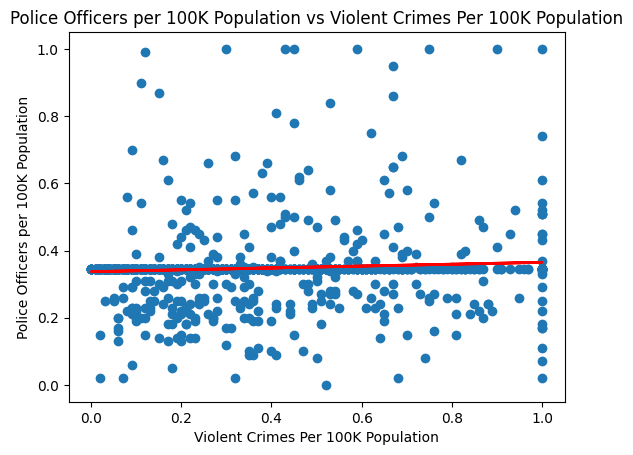

In [ ]:
#plotting the data
plt.scatter(policePop_crime['violentCrimesPerPop'], policePop_crime['policPerPop'])

#making and plotting the best fit line
coeff, intercept = np.polyfit(policePop_crime['violentCrimesPerPop'], policePop_crime['policPerPop'], 1)
line = coeff * policePop_crime['policPerPop'] + intercept
plt.plot(policePop_crime['policPerPop'], line, color='red', linewidth=2, label='Linear Regression')

plt.title('Police Officers per 100K Population vs Violent Crimes Per 100K Population')
plt.ylabel("Police Officers per 100K Population")
plt.xlabel('Violent Crimes Per 100K Population')
plt.show()

*Analysis*:  This graph shows a very small positive correlation between the number of police per 100K population and number of violent crimes per 100K population.

Null Hypothesis: There is no correlation between the number of police per 100K population and crime rate.

Alternative hypothesis: There is a positive correlation between the number of police per 100K population and crime rate.

In [ ]:
crosstab = pd.crosstab(policePop_crime['policPerPop'], policePop_crime['violentCrimesPerPop'])
chi2, p, dof, expected = chi2_contingency(crosstab)
print("chi square:", chi2)
print("p-value:", p)
print("expected: ", expected)
print("critical value:", scipy.stats.chi2.ppf(.95, dof))

chi square: 13674.007597823838
p-value: 0.0
expected:  [[0.00501505 0.01905717 0.03711133 ... 0.0005015  0.00100301 0.0220662 ]
 [0.02507523 0.09528586 0.18555667 ... 0.00250752 0.00501505 0.11033099]
 [0.00501505 0.01905717 0.03711133 ... 0.0005015  0.00100301 0.0220662 ]
 ...
 [0.00501505 0.01905717 0.03711133 ... 0.0005015  0.00100301 0.0220662 ]
 [0.00501505 0.01905717 0.03711133 ... 0.0005015  0.00100301 0.0220662 ]
 [0.03510532 0.1334002  0.25977934 ... 0.00351053 0.00702106 0.15446339]]
critical value: 7474.538310915513


**Conclusion**: Since the chi squared statistic is greater than the critical value there is a positive correlation. It's statistically significant because the p-value is close to or equal to 0. This means we can reject the null hypothesis

**Hypotheses 4:** There is a correlation between the population of those who are below the poverty line and police presence


In [ ]:
pov_pop_presence = df[['pctPopUnderPov','policPerPop','lemasTotalReg','policAvOTWorked','policBudgPerPop','lemasPctOfficDrugUn','lemasGangUnitDeploy']].dropna()
pov_pop_presence.head()

,pctPopUnderPov,policPerPop,lemasTotalReg,policAvOTWorked,policBudgPerPop,lemasPctOfficDrugUn,lemasGangUnitDeploy
0,0.19,0.440000,0.170000,0.57000,0.140000,0.32,0.900000
1,0.24,0.343636,0.246332,0.55605,0.195078,0.00,0.698589
2,0.27,0.343636,0.246332,0.55605,0.195078,0.00,0.698589
3,0.10,0.343636,0.246332,0.55605,0.195078,0.00,0.698589
4,0.06,0.343636,0.246332,0.55605,0.195078,0.00,0.698589


In [ ]:
#temp analysis
new_df = communities_df.copy().dropna()
correlation_matrix = pov_pop_presence.corr()
corr_pov_pop_presence = correlation_matrix['pctPopUnderPov'].drop('pctPopUnderPov')
print(corr_pov_pop_presence)
# corr_pov_pop_presence.plot(kind = 'barh')

# plt.scatter(corr_pov_pop_presence.values, corr_pov_pop_presence.index)


policPerPop            0.030908
lemasTotalReg          0.015731
policAvOTWorked        0.007604
policBudgPerPop       -0.027302
lemasPctOfficDrugUn    0.170169
lemasGangUnitDeploy   -0.042947
Name: pctPopUnderPov, dtype: float64


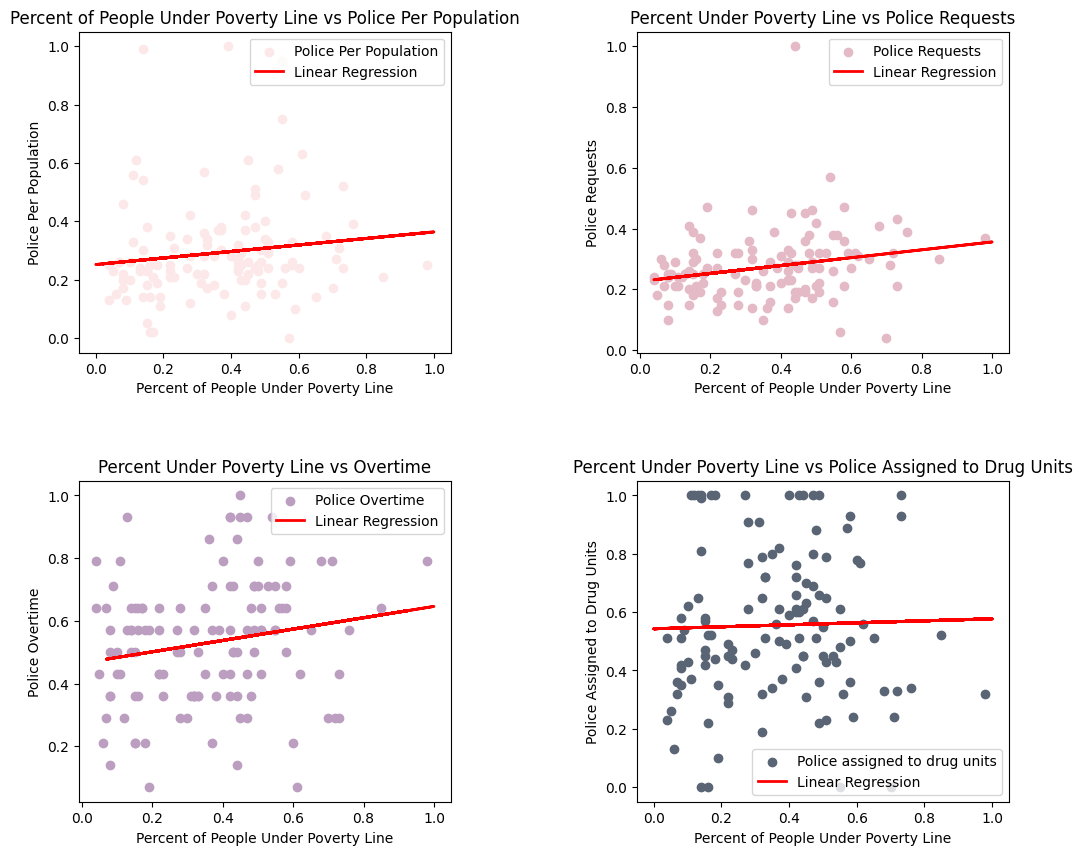

In [ ]:
#'policPerPop','lemasTotalReg','policAvOTWorked','policBudgPerPop','lemasPctOfficDrugUn','lemasGangUnitDeploy'
new_df = communities_df.copy().dropna()


fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].scatter(new_df['pctPopUnderPov'].astype(float), new_df['policPerPop'].astype(float),c='#FDE8E9', label='Police Per Population')

coeff, intercept = np.polyfit(new_df['pctPopUnderPov'].astype(float), new_df['policPerPop'].astype(float), 1)
line = coeff * new_df['policPerPop'].astype(float) + intercept
axs[0, 0].plot(new_df['policPerPop'].astype(float), line, color='red', linewidth=2, label='Linear Regression')

axs[0, 0].set_title('Percent of People Under Poverty Line vs Police Per Population')
axs[0, 0].set(ylabel = "Police Per Population")
axs[0, 0].set(xlabel = 'Percent of People Under Poverty Line')


axs[0, 1].scatter(new_df['pctPopUnderPov'].astype(float), new_df['lemasTotalReg'].astype(float), c='#E3BAC6', label='Police Requests')

coeff, intercept = np.polyfit(new_df['pctPopUnderPov'].astype(float), new_df['lemasTotalReg'].astype(float), 1)
line = coeff * new_df['lemasTotalReg'].astype(float) + intercept
axs[0, 1].plot(new_df['lemasTotalReg'].astype(float), line, color='red', linewidth=2, label='Linear Regression')

axs[0, 1].set_title('Percent Under Poverty Line vs Police Requests')
axs[0, 1].set(ylabel = "Police Requests")
axs[0, 1].set(xlabel = 'Percent of People Under Poverty Line')


axs[1, 0].scatter(new_df['pctPopUnderPov'].astype(float), new_df['policAvOTWorked'].astype(float), c='#BC9EC1', label='Police Overtime')

coeff, intercept = np.polyfit(new_df['pctPopUnderPov'].astype(float), new_df['policAvOTWorked'].astype(float), 1)
line = coeff * new_df['policAvOTWorked'].astype(float) + intercept
axs[1, 0].plot(new_df['policAvOTWorked'].astype(float), line, color='red', linewidth=2, label='Linear Regression')

axs[1, 0].set_title('Percent Under Poverty Line vs Overtime')
axs[1, 0].set(ylabel = "Police Overtime")
axs[1, 0].set(xlabel = 'Percent of People Under Poverty Line')


axs[1, 1].scatter(new_df['pctPopUnderPov'].astype(float), new_df['lemasPctOfficDrugUn'].astype(float), c='#596475', label='Police assigned to drug units')

coeff, intercept = np.polyfit(new_df['pctPopUnderPov'].astype(float), new_df['lemasPctOfficDrugUn'].astype(float), 1)
line = coeff * new_df['lemasPctOfficDrugUn'].astype(float) + intercept
axs[1, 1].plot(new_df['lemasPctOfficDrugUn'].astype(float), line, color='red', linewidth=2, label='Linear Regression')

axs[1, 1].set_title('Percent Under Poverty Line vs Police Assigned to Drug Units')
axs[1, 1].set(ylabel = "Police Assigned to Drug Units")
axs[1, 1].set(xlabel = 'Percent of People Under Poverty Line')

axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()


plt.subplots_adjust(hspace = .4, wspace= .5)
plt.show()


Text(0.5, 0, 'Percent of People Under Poverty Line')

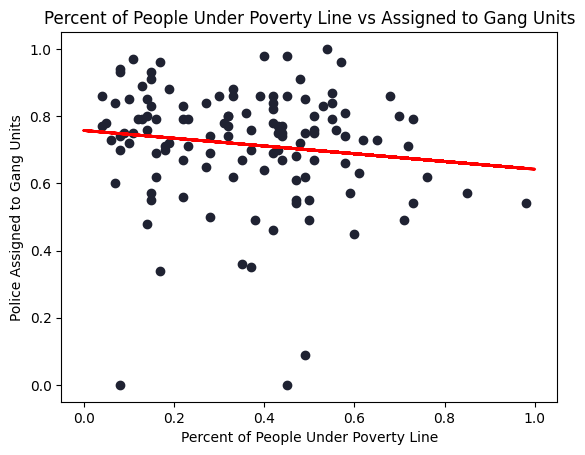

In [ ]:
plt.scatter(new_df['pctPopUnderPov'].astype(float), new_df['lemasGangUnitDeploy'].astype(float), c='#1F2232', label='Police assigned to drug units')

coeff, intercept = np.polyfit(new_df['pctPopUnderPov'].astype(float), new_df['lemasGangUnitDeploy'].astype(float), 1)
line = coeff * new_df['lemasGangUnitDeploy'].astype(float) + intercept
plt.plot(new_df['lemasGangUnitDeploy'].astype(float), line, color='red', linewidth=2, label='Linear Regression')

plt.title('Percent of People Under Poverty Line vs Assigned to Gang Units')
plt.ylabel("Police Assigned to Gang Units")
plt.xlabel('Percent of People Under Poverty Line')

**Analysis**: The percentage of people under the poverty line seems to increase as the number of police perpopulation, the total police requests, the overtime police worked, and the percentage of police assigned to drug units all increase.

The percentage of people under the poverty line seems to decrease as police budget, and units assigned to gangs all increase.

**Null Hypothesis:** There is no correlation between policy activity and poverty.

In [ ]:
crosstab = pd.crosstab(pov_pop_presence['pctPopUnderPov'], pov_pop_presence['policPerPop'])
chi2, p, dof, expected = chi2_contingency(crosstab)
print('policPerPop')
print("chi square:", chi2)
print("p-value:", p)
print("expected: ", expected)
print("critical value:", scipy.stats.chi2.ppf(.95, dof))

policPerPop
chi square: 8005.073467450596
p-value: 1.6841894754682825e-06
expected:  [[0.00150451 0.00752257 0.00150451 ... 0.00150451 0.00150451 0.01053159]
 [0.00451354 0.0225677  0.00451354 ... 0.00451354 0.00451354 0.03159478]
 [0.01203611 0.06018054 0.01203611 ... 0.01203611 0.01203611 0.08425276]
 ...
 [0.00100301 0.00501505 0.00100301 ... 0.00100301 0.00100301 0.00702106]
 [0.00150451 0.00752257 0.00150451 ... 0.00150451 0.00150451 0.01053159]
 [0.01253761 0.06268806 0.01253761 ... 0.01253761 0.01253761 0.08776329]]
critical value: 7626.573382409422


In [ ]:
#'policPerPop','lemasTotalReg','policAvOTWorked','policBudgPerPop','lemasPctOfficDrugUn','lemasGangUnitDeploy'


crosstab = pd.crosstab(pov_pop_presence['pctPopUnderPov'], pov_pop_presence['lemasTotalReg'])
chi2, p, dof, expected = chi2_contingency(crosstab)
print('policAvOTWorked')
print("chi square:", chi2)
print("p-value:", p)
print("expected: ", expected)
print("critical value:", scipy.stats.chi2.ppf(.95, dof))

policAvOTWorked
chi square: 7329.559021127432
p-value: 3.4342355418976924e-60
expected:  [[0.00150451 0.00300903 0.00451354 ... 0.00150451 0.00150451 0.00752257]
 [0.00451354 0.00902708 0.01354062 ... 0.00451354 0.00451354 0.0225677 ]
 [0.01203611 0.02407222 0.03610832 ... 0.01203611 0.01203611 0.06018054]
 ...
 [0.00100301 0.00200602 0.00300903 ... 0.00100301 0.00100301 0.00501505]
 [0.00150451 0.00300903 0.00451354 ... 0.00150451 0.00150451 0.00752257]
 [0.01253761 0.02507523 0.03761284 ... 0.01253761 0.01253761 0.06268806]]
critical value: 5617.778453517896


In [ ]:
#'policPerPop','lemasTotalReg','policAvOTWorked','policBudgPerPop','lemasPctOfficDrugUn','lemasGangUnitDeploy'


crosstab = pd.crosstab(pov_pop_presence['pctPopUnderPov'], pov_pop_presence['policAvOTWorked'])
chi2, p, dof, expected = chi2_contingency(crosstab)
print('policBudgPerPop')

print("chi square:", chi2)
print("p-value:", p)
print("expected: ", expected)
print("critical value:", scipy.stats.chi2.ppf(.95, dof))

policBudgPerPop
chi square: 1645.440642444804
p-value: 0.0021429823221331534
expected:  [[0.00300903 0.00451354 0.01053159 ... 0.01955868 0.03159478 0.00300903]
 [0.00902708 0.01354062 0.03159478 ... 0.05867603 0.09478435 0.00902708]
 [0.02407222 0.03610832 0.08425276 ... 0.15646941 0.25275827 0.02407222]
 ...
 [0.00200602 0.00300903 0.00702106 ... 0.01303912 0.02106319 0.00200602]
 [0.00300903 0.00451354 0.01053159 ... 0.01955868 0.03159478 0.00300903]
 [0.02507523 0.03761284 0.08776329 ... 0.16298897 0.26328987 0.02507523]]
critical value: 1575.7632957444946


In [ ]:
#'policPerPop','lemasTotalReg','policAvOTWorked','policBudgPerPop','lemasPctOfficDrugUn','lemasGangUnitDeploy'


crosstab = pd.crosstab(pov_pop_presence['pctPopUnderPov'], pov_pop_presence['policBudgPerPop'])
chi2, p, dof, expected = chi2_contingency(crosstab)
print('lemasPctOfficDrugUn')

print("chi square:", chi2)
print("p-value:", p)
print(dof)
print("expected: ", expected)
print("critical value:", scipy.stats.chi2.ppf(.95, dof))

lemasPctOfficDrugUn
chi square: 6225.527543223081
p-value: 5.065563000923271e-28
5049
expected:  [[0.00300903 0.00150451 0.00451354 ... 0.00150451 0.00150451 0.00902708]
 [0.00902708 0.00451354 0.01354062 ... 0.00451354 0.00451354 0.02708124]
 [0.02407222 0.01203611 0.03610832 ... 0.01203611 0.01203611 0.07221665]
 ...
 [0.00200602 0.00100301 0.00300903 ... 0.00100301 0.00100301 0.00601805]
 [0.00300903 0.00150451 0.00451354 ... 0.00150451 0.00150451 0.00902708]
 [0.02507523 0.01253761 0.03761284 ... 0.01253761 0.01253761 0.07522568]]
critical value: 5215.4185703365


In [ ]:
#'policPerPop','lemasTotalReg','policAvOTWorked','policBudgPerPop','lemasPctOfficDrugUn','lemasGangUnitDeploy'


crosstab = pd.crosstab(pov_pop_presence['pctPopUnderPov'], pov_pop_presence['lemasPctOfficDrugUn'])
chi2, p, dof, expected = chi2_contingency(crosstab)
print('lemasGangUnitDeploy')

print("chi square:", chi2)
print("p-value:", p)
print(dof)
print("expected: ", expected)
print("critical value:", scipy.stats.chi2.ppf(.95, dof))

lemasGangUnitDeploy
chi square: 8311.566836408345
p-value: 5.9404576468861574e-05
7821
expected:  [[2.53510532e+00 1.50451354e-03 1.50451354e-03 ... 3.00902708e-03
  4.51354062e-03 7.22166499e-02]
 [7.60531595e+00 4.51354062e-03 4.51354062e-03 ... 9.02708124e-03
  1.35406219e-02 2.16649950e-01]
 [2.02808425e+01 1.20361083e-02 1.20361083e-02 ... 2.40722166e-02
  3.61083250e-02 5.77733200e-01]
 ...
 [1.69007021e+00 1.00300903e-03 1.00300903e-03 ... 2.00601805e-03
  3.00902708e-03 4.81444333e-02]
 [2.53510532e+00 1.50451354e-03 1.50451354e-03 ... 3.00902708e-03
  4.51354062e-03 7.22166499e-02]
 [2.11258776e+01 1.25376128e-02 1.25376128e-02 ... 2.50752257e-02
  3.76128385e-02 6.01805416e-01]]
critical value: 8027.849260889847


**Conclusion:** Percent of people under the poverty line is positively correlated with, police per  100k people, police requests, police overtime, and police assigned to drug units. Surprisingly, the number of police assigned to gang units is negatively correlated with the percent of people under the poverty line, and police budget per population. These results are also statistically significant. This shows police activity is correlated with the percent of people under the poverty line. However, we do not know which is the cause or effect.

**Hypotheses 5:** There is a correlation between those who live within an area that is “urban” and police presence

In [ ]:
pov_urban = df[['numUrban','policPerPop','lemasTotalReg','policAvOTWorked','policBudgPerPop','lemasPctOfficDrugUn','lemasGangUnitDeploy']].dropna()
pov_urban.head()

,numUrban,policPerPop,lemasTotalReg,policAvOTWorked,policBudgPerPop,lemasPctOfficDrugUn,lemasGangUnitDeploy
0,0.20,0.440000,0.170000,0.57000,0.140000,0.32,0.900000
1,0.02,0.343636,0.246332,0.55605,0.195078,0.00,0.698589
2,0.00,0.343636,0.246332,0.55605,0.195078,0.00,0.698589
3,0.06,0.343636,0.246332,0.55605,0.195078,0.00,0.698589
4,0.02,0.343636,0.246332,0.55605,0.195078,0.00,0.698589


In [ ]:

correlation_matrix = pov_urban.corr()
pov_urban_c = correlation_matrix['numUrban'].drop('numUrban')
print(pov_urban_c)

policPerPop            0.134236
lemasTotalReg         -0.070525
policAvOTWorked        0.249489
policBudgPerPop       -0.036114
lemasPctOfficDrugUn    0.478179
lemasGangUnitDeploy   -0.058712
Name: numUrban, dtype: float64


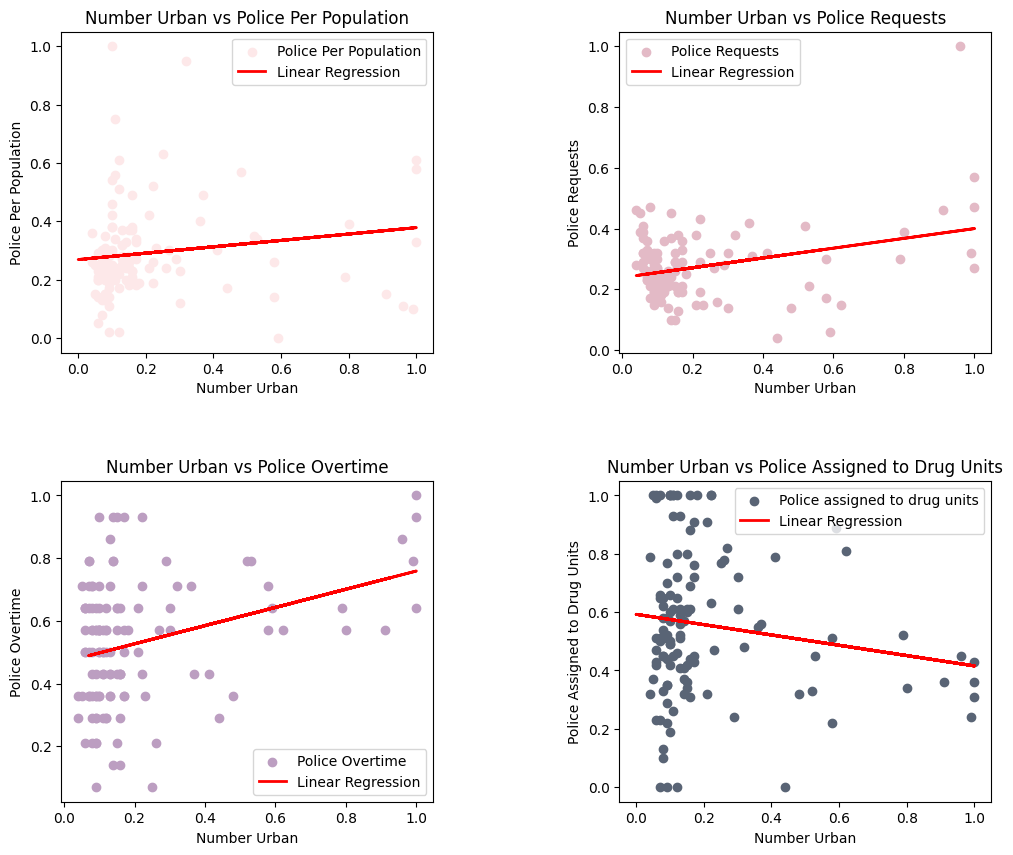

In [ ]:
#'policPerPop','lemasTotalReg','policAvOTWorked','policBudgPerPop','lemasPctOfficDrugUn','lemasGangUnitDeploy'
corr_df = communities_df.dropna()
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].scatter(new_df['numUrban'].astype(float), new_df['policPerPop'].astype(float),c='#FDE8E9', label='Police Per Population')

coeff, intercept = np.polyfit(new_df['numUrban'].astype(float), new_df['policPerPop'].astype(float), 1)
line = coeff * new_df['policPerPop'].astype(float) + intercept
axs[0, 0].plot(new_df['policPerPop'].astype(float), line, color='red', linewidth=2, label='Linear Regression')

axs[0, 0].set_title('Number Urban vs Police Per Population')
axs[0, 0].set(ylabel = "Police Per Population")
axs[0, 0].set(xlabel = 'Number Urban')


axs[0, 1].scatter(new_df['numUrban'].astype(float), new_df['lemasTotalReg'].astype(float), c='#E3BAC6', label='Police Requests')

coeff, intercept = np.polyfit(new_df['numUrban'].astype(float), new_df['lemasTotalReg'].astype(float), 1)
line = coeff * new_df['lemasTotalReg'].astype(float) + intercept
axs[0, 1].plot(new_df['lemasTotalReg'].astype(float), line, color='red', linewidth=2, label='Linear Regression')

axs[0, 1].set_title('Number Urban vs Police Requests')
axs[0, 1].set(ylabel = "Police Requests")
axs[0, 1].set(xlabel = 'Number Urban')


axs[1, 0].scatter(new_df['numUrban'].astype(float), new_df['policAvOTWorked'].astype(float), c='#BC9EC1', label='Police Overtime')

coeff, intercept = np.polyfit(new_df['numUrban'].astype(float), new_df['policAvOTWorked'].astype(float), 1)
line = coeff * new_df['policAvOTWorked'].astype(float) + intercept
axs[1, 0].plot(new_df['policAvOTWorked'].astype(float), line, color='red', linewidth=2, label='Linear Regression')

axs[1, 0].set_title('Number Urban vs Police Overtime')
axs[1, 0].set(ylabel = "Police Overtime")
axs[1, 0].set(xlabel = 'Number Urban')


axs[1, 1].scatter(new_df['numUrban'].astype(float), new_df['lemasPctOfficDrugUn'].astype(float), c='#596475', label='Police assigned to drug units')

coeff, intercept = np.polyfit(new_df['numUrban'].astype(float), new_df['lemasPctOfficDrugUn'].astype(float), 1)
line = coeff * new_df['lemasPctOfficDrugUn'].astype(float) + intercept
axs[1, 1].plot(new_df['lemasPctOfficDrugUn'].astype(float), line, color='red', linewidth=2, label='Linear Regression')

axs[1, 1].set_title('Number Urban vs Police Assigned to Drug Units')
axs[1, 1].set(ylabel = "Police Assigned to Drug Units")
axs[1, 1].set(xlabel = 'Number Urban')

axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()


plt.subplots_adjust(hspace = .4, wspace= .5)
plt.show()


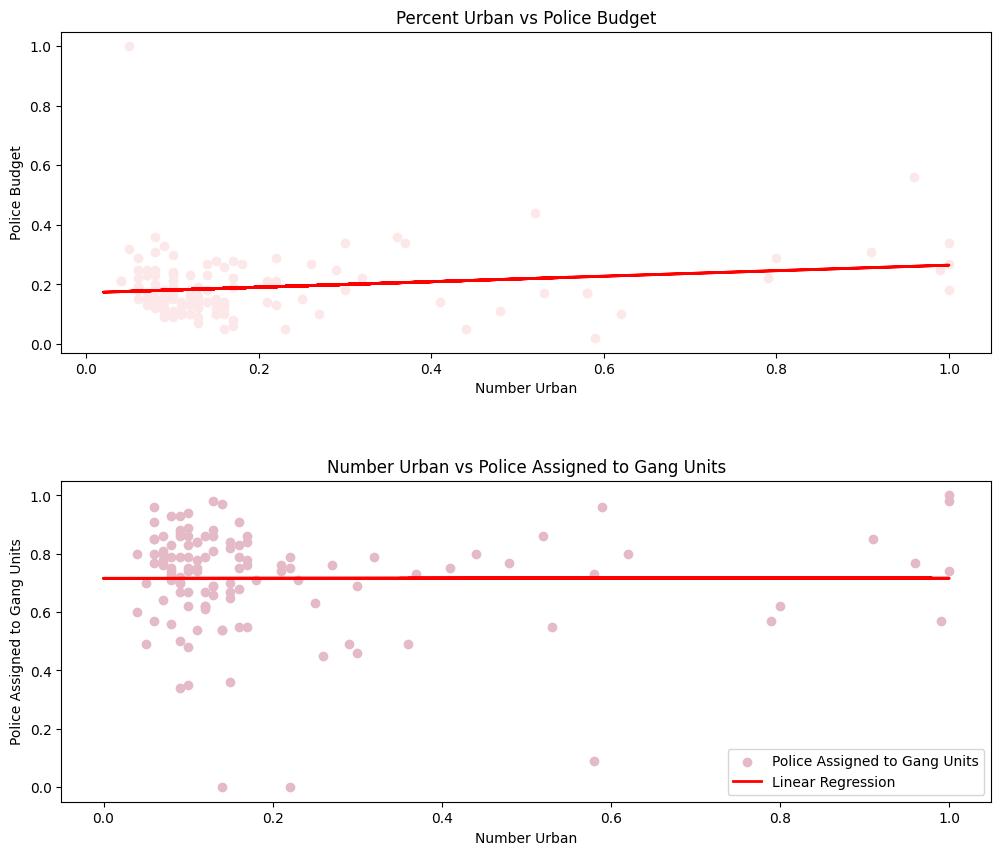

In [ ]:
#'policPerPop','lemasTotalReg','policAvOTWorked','policBudgPerPop','lemasPctOfficDrugUn','lemasGangUnitDeploy'
new_df = communities_df.dropna()
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
axs[0].scatter(new_df['numUrban'].astype(float), new_df['policBudgPerPop'].astype(float),c='#FDE8E9', label='Police Budget')

coeff, intercept = np.polyfit(new_df['numUrban'].astype(float), new_df['policBudgPerPop'].astype(float), 1)
line = coeff * new_df['policBudgPerPop'].astype(float) + intercept
axs[0].plot(new_df['policBudgPerPop'].astype(float), line, color='red', linewidth=2, label='Linear Regression')

axs[0].set_title('Percent Urban vs Police Budget')
axs[0].set(ylabel = "Police Budget")
axs[0].set(xlabel = 'Number Urban')


axs[1].scatter(new_df['numUrban'].astype(float), new_df['lemasGangUnitDeploy'].astype(float), c='#E3BAC6', label='Police Assigned to Gang Units')

coeff, intercept = np.polyfit(new_df['numUrban'].astype(float), new_df['lemasGangUnitDeploy'].astype(float), 1)
line = coeff * new_df['lemasGangUnitDeploy'].astype(float) + intercept
axs[1].plot(new_df['lemasGangUnitDeploy'].astype(float), line, color='red', linewidth=2, label='Linear Regression')

axs[1].set_title('Number Urban vs Police Assigned to Gang Units')
axs[1].set(ylabel = "Police Assigned to Gang Units")
axs[1].set(xlabel = 'Number Urban')

axs[1].legend()



plt.subplots_adjust(hspace = .4, wspace= .5)
plt.show()


**Analysis**: The number of people in "urban" places seems to increase as the police per population, the total police requests, overtime police work, and and police budget.






The number of people in "urban" places seems to decrease as police assigned to drug units, police assigned to gang units, and police budget increase.


**Alt Hypotheses**: Some police activity is correlated with the number of people in urban areas




**Null Hypothesis**: There is no correlation between policy activity and the number of people in "urban" areas.





In [ ]:
#'numUrban','policPerPop','lemasTotalReg','policAvOTWorked','policBudgPerPop','lemasPctOfficDrugUn','lemasGangUnitDeploy'

crosstab = pd.crosstab(pov_urban['numUrban'], pov_urban['policPerPop'])
chi2, p, dof, expected = chi2_contingency(crosstab)
print('policPerPop')
print("chi square:", chi2)
print("p-value:", p)
print("expected: ", expected)
print("critical value:", scipy.stats.chi2.ppf(.95, dof))

policPerPop
chi square: 31016.453929118717
p-value: 0.0
expected:  [[2.84854564e-01 1.42427282e+00 2.84854564e-01 ... 2.84854564e-01
  2.84854564e-01 1.99398195e+00]
 [1.85556670e-02 9.27783350e-02 1.85556670e-02 ... 1.85556670e-02
  1.85556670e-02 1.29889669e-01]
 [1.64994985e-01 8.24974925e-01 1.64994985e-01 ... 1.64994985e-01
  1.64994985e-01 1.15496489e+00]
 ...
 [5.01504514e-04 2.50752257e-03 5.01504514e-04 ... 5.01504514e-04
  5.01504514e-04 3.51053159e-03]
 [5.01504514e-04 2.50752257e-03 5.01504514e-04 ... 5.01504514e-04
  5.01504514e-04 3.51053159e-03]
 [6.51955868e-03 3.25977934e-02 6.51955868e-03 ... 6.51955868e-03
  6.51955868e-03 4.56369107e-02]]
critical value: 5114.789985665257


In [ ]:
#'numUrban','policPerPop','lemasTotalReg','policAvOTWorked','policBudgPerPop','lemasPctOfficDrugUn','lemasGangUnitDeploy'

crosstab = pd.crosstab(pov_urban['numUrban'], pov_urban['lemasTotalReg'])
chi2, p, dof, expected = chi2_contingency(crosstab)
print('lemasTotalReg')

print("chi square:", chi2)
print("p-value:", p)
print("expected: ", expected)
print("critical value:", scipy.stats.chi2.ppf(.95, dof))

lemasTotalReg
chi square: 20195.417159494682
p-value: 0.0
expected:  [[2.84854564e-01 5.69709127e-01 8.54563691e-01 ... 2.84854564e-01
  2.84854564e-01 1.42427282e+00]
 [1.85556670e-02 3.71113340e-02 5.56670010e-02 ... 1.85556670e-02
  1.85556670e-02 9.27783350e-02]
 [1.64994985e-01 3.29989970e-01 4.94984955e-01 ... 1.64994985e-01
  1.64994985e-01 8.24974925e-01]
 ...
 [5.01504514e-04 1.00300903e-03 1.50451354e-03 ... 5.01504514e-04
  5.01504514e-04 2.50752257e-03]
 [5.01504514e-04 1.00300903e-03 1.50451354e-03 ... 5.01504514e-04
  5.01504514e-04 2.50752257e-03]
 [6.51955868e-03 1.30391174e-02 1.95586760e-02 ... 6.51955868e-03
  6.51955868e-03 3.25977934e-02]]
critical value: 3771.2785795577115


In [ ]:
#'numUrban','policPerPop','lemasTotalReg','policAvOTWorked','policBudgPerPop','lemasPctOfficDrugUn','lemasGangUnitDeploy'

crosstab = pd.crosstab(pov_urban['numUrban'], pov_urban['policAvOTWorked'])
chi2, p, dof, expected = chi2_contingency(crosstab)
print('policAvOTWorked')
print("chi square:", chi2)
print("p-value:", p)
print("expected: ", expected)
print("critical value:", scipy.stats.chi2.ppf(.95, dof))

policAvOTWorked
chi square: 5473.75596303586
p-value: 0.0
expected:  [[5.69709127e-01 8.54563691e-01 1.99398195e+00 ... 3.70310933e+00
  5.98194584e+00 5.69709127e-01]
 [3.71113340e-02 5.56670010e-02 1.29889669e-01 ... 2.41223671e-01
  3.89669007e-01 3.71113340e-02]
 [3.29989970e-01 4.94984955e-01 1.15496489e+00 ... 2.14493480e+00
  3.46489468e+00 3.29989970e-01]
 ...
 [1.00300903e-03 1.50451354e-03 3.51053159e-03 ... 6.51955868e-03
  1.05315948e-02 1.00300903e-03]
 [1.00300903e-03 1.50451354e-03 3.51053159e-03 ... 6.51955868e-03
  1.05315948e-02 1.00300903e-03]
 [1.30391174e-02 1.95586760e-02 4.56369107e-02 ... 8.47542628e-02
  1.36910732e-01 1.30391174e-02]]
critical value: 1064.310634603235


In [ ]:
#'numUrban','policPerPop','lemasTotalReg','policAvOTWorked','policBudgPerPop','lemasPctOfficDrugUn','lemasGangUnitDeploy'

crosstab = pd.crosstab(pov_urban['numUrban'], pov_urban['policBudgPerPop'])
chi2, p, dof, expected = chi2_contingency(crosstab)
print('policBudgPerPop')
print("chi square:", chi2)
print("p-value:", p)
print("expected: ", expected)
print("critical value:", scipy.stats.chi2.ppf(.95, dof))

policBudgPerPop
chi square: 23243.66093062066
p-value: 0.0
expected:  [[5.69709127e-01 2.84854564e-01 8.54563691e-01 ... 2.84854564e-01
  2.84854564e-01 1.70912738e+00]
 [3.71113340e-02 1.85556670e-02 5.56670010e-02 ... 1.85556670e-02
  1.85556670e-02 1.11334002e-01]
 [3.29989970e-01 1.64994985e-01 4.94984955e-01 ... 1.64994985e-01
  1.64994985e-01 9.89969910e-01]
 ...
 [1.00300903e-03 5.01504514e-04 1.50451354e-03 ... 5.01504514e-04
  5.01504514e-04 3.00902708e-03]
 [1.00300903e-03 5.01504514e-04 1.50451354e-03 ... 5.01504514e-04
  5.01504514e-04 3.00902708e-03]
 [1.30391174e-02 6.51955868e-03 1.95586760e-02 ... 6.51955868e-03
  6.51955868e-03 3.91173521e-02]]
critical value: 3502.085637359924


In [ ]:
#'numUrban','policPerPop','lemasTotalReg','policAvOTWorked','policBudgPerPop','lemasPctOfficDrugUn','lemasGangUnitDeploy'

crosstab = pd.crosstab(pov_urban['numUrban'], pov_urban['lemasPctOfficDrugUn'])
chi2, p, dof, expected = chi2_contingency(crosstab)
print('lemasPctOfficDrugUn')
print("chi square:", chi2)
print("p-value:", p)
print("expected: ", expected)
print("critical value:", scipy.stats.chi2.ppf(.95, dof))

lemasPctOfficDrugUn
chi square: 27458.82421456407
p-value: 0.0
expected:  [[4.79979940e+02 2.84854564e-01 2.84854564e-01 ... 5.69709127e-01
  8.54563691e-01 1.36730191e+01]
 [3.12662989e+01 1.85556670e-02 1.85556670e-02 ... 3.71113340e-02
  5.56670010e-02 8.90672016e-01]
 [2.78016550e+02 1.64994985e-01 1.64994985e-01 ... 3.29989970e-01
  4.94984955e-01 7.91975928e+00]
 ...
 [8.45035105e-01 5.01504514e-04 5.01504514e-04 ... 1.00300903e-03
  1.50451354e-03 2.40722166e-02]
 [8.45035105e-01 5.01504514e-04 5.01504514e-04 ... 1.00300903e-03
  1.50451354e-03 2.40722166e-02]
 [1.09854564e+01 6.51955868e-03 6.51955868e-03 ... 1.30391174e-02
  1.95586760e-02 3.12938816e-01]]
critical value: 5383.0977904012925


In [ ]:
#'numUrban','policPerPop','lemasTotalReg','policAvOTWorked','policBudgPerPop','lemasPctOfficDrugUn','lemasGangUnitDeploy'

crosstab = pd.crosstab(pov_urban['numUrban'], pov_urban['lemasGangUnitDeploy'])
chi2, p, dof, expected = chi2_contingency(crosstab)
print('lemasGangUnitDeploy')
print("chi square:", chi2)
print("p-value:", p)
print("expected: ", expected)
print("critical value:", scipy.stats.chi2.ppf(.95, dof))

lemasGangUnitDeploy
chi square: 24448.908035370125
p-value: 0.0
expected:  [[2.56369107e+00 2.84854564e-01 2.84854564e-01 ... 8.54563691e-01
  2.84854564e-01 2.84854564e-01]
 [1.67001003e-01 1.85556670e-02 1.85556670e-02 ... 5.56670010e-02
  1.85556670e-02 1.85556670e-02]
 [1.48495486e+00 1.64994985e-01 1.64994985e-01 ... 4.94984955e-01
  1.64994985e-01 1.64994985e-01]
 ...
 [4.51354062e-03 5.01504514e-04 5.01504514e-04 ... 1.50451354e-03
  5.01504514e-04 5.01504514e-04]
 [4.51354062e-03 5.01504514e-04 5.01504514e-04 ... 1.50451354e-03
  5.01504514e-04 5.01504514e-04]
 [5.86760281e-02 6.51955868e-03 6.51955868e-03 ... 1.95586760e-02
  6.51955868e-03 6.51955868e-03]]
critical value: 4913.483200939299


**Conclusion**: All p values are less than .05, and all chi square values are greater than their given critical value. This means that the number of people in urban areas is positively correlated with police per population, total police requests, and police overtime. It also means that these statistics are significant.








The number of people in urban areas is negatively correlated with drug units, police assigned to gang units, and police budget.







# **Prepping for Training**

In [ ]:
## Creating new copy of original Dataframe

training_df = communities_df

In [ ]:
training_df.head()

,state,county,community,communityname,fold,population,householdsize,racePctBlack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInv,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,asianPerCap,otherPerCap,hispPerCap,numUnderPov,pctPopUnderPov,pctLess9thGrade,pctNotHSGrad,pctBSorMore,pctUnemployed,pctEmploy,pctEmplManu,pctEmplProfServ,pctOccupManu,pctOccupMgmtProf,malePctDivorce,malePctNevMarr,femalePctDiv,totalPctDiv,persPerFam,pctFam2Par,pctKids2Par,pctYoungKids2Par,pctTeen2Par,pctWorkMomYoungKids,pctWorkMom,numIlleg,pctIlleg,numIlleg.1,pctImmigRecent,pctImmigRec5,pctImmigRec8,pctImmigRec10,pctRecentImmig,pctRecImmig5,pctRecImmig8,pctRecImmig10,pctSpeakEngOnly,pctNotSpeakEngWell,pctLargHouseFam,pctLargHouseOccup,persPerOccupHous,persPerOwnOccHouse,persPerRentOccHouse,pctPersOwnOccup,pctPersDenceHous,pctHouseLess3BR,medNumBR,housVacant,pctHouseOccup,pctHouseOwnOcc,pctVacantBoarded,pctVacMore6Mos,medYrHousBuilt,pctHousNoPhone,pctWOFullPlumb,ownOccLowQuart,ownOccMedVal,ownOccHiQuart,rentLowQ,rentMedian,rentHighQ,medRent,medRentPctHousInc,medOwnCostPctInc,medOwnCostPctIncNoMtg,numInShelters,numStreet,pctForeignBorn,pctBornSameState,pctSameHouse85,pctSameCity85,lemasSwornFT,lemasSwFTPerPop,lemasSwFTFieldOps,lemasSwFTFieldPerPop,lemasTotalReg,lemasTotRegPerPop,policeReqPerOffic,policPerPop,racialMatchCommPol,pctPolicWhite,pctPolicBlack,pctPolicHisp,pctPolicAsian,pctPolicMinor,officAssgnDrugUnits,numKindsDrugsSeiz,policAvOTWorked,landArea,popDens,pctUsePubTrans,policCars,policOperBudg,lemasPctPolicOnPatr,lemasGangUnitDeploy,lemasGangUnitDeploy.1,lemasPctOfficDrugUn,policBudgPerPop,violentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,0.75,0.75,0.35,0.55,0.59,0.61,0.56,0.74,0.76,0.04,0.14,0.03,0.24,0.27,0.37,0.39,0.07,0.07,0.08,0.08,0.89,0.06,0.14,0.13,0.33,0.39,0.28,0.55,0.09,0.51,0.5,0.21,0.71,0.52,0.05,0.26,0.65,0.14,0.06,0.22,0.19,0.18,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,0.91,1.00,0.29,0.43,0.47,0.60,0.39,0.46,0.53,0.00,0.24,0.01,0.52,0.62,0.64,0.63,0.25,0.27,0.25,0.23,0.84,0.10,0.16,0.10,0.17,0.29,0.17,0.26,0.20,0.82,0.0,0.02,0.79,0.24,0.02,0.25,0.65,0.16,0.00,0.21,0.20,0.21,0.42,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,0.71,0.70,0.45,0.42,0.44,0.43,0.43,0.71,0.67,0.01,0.46,0.00,0.07,0.06,0.15,0.19,0.02,0.02,0.04,0.05,0.88,0.04,0.20,0.20,0.46,0.52,0.43,0.42,0.15,0.51,0.5,0.01,0.86,0.41,0.29,0.30,0.52,0.47,0.45,0.18,0.17,0.16,0.27,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,0.45,0.37,0.39,0.34,0.45,0.49,0.44,0.75,0.65,0.54,0.83,0.65,0.85,0.86,0.03,0.33,0.02,0.11,0.20,0.30,0.31,0.05,0.08,0.11,0.11,0.81,0.08,0.56,0.62,0.85,0.77,1.00,0

In [ ]:
#Replacing ?'s with NaN values
training_df.replace('?', np.NaN, inplace=True)

In [ ]:
#Using Iterative Imputation (Regression) to replace values with most probable values
columns_to_iterate = training_df.columns[4:]

for column in columns_to_iterate:
    column_to_impute = training_df[[column]]

    imputing = IterativeImputer()
    arr = imputing.fit_transform(column_to_impute)

    new_df = pd.DataFrame(arr)

    training_df[column] = new_df

In [ ]:
training_df.head()

,state,county,community,communityname,fold,population,householdsize,racePctBlack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInv,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,asianPerCap,otherPerCap,hispPerCap,numUnderPov,pctPopUnderPov,pctLess9thGrade,pctNotHSGrad,pctBSorMore,pctUnemployed,pctEmploy,pctEmplManu,pctEmplProfServ,pctOccupManu,pctOccupMgmtProf,malePctDivorce,malePctNevMarr,femalePctDiv,totalPctDiv,persPerFam,pctFam2Par,pctKids2Par,pctYoungKids2Par,pctTeen2Par,pctWorkMomYoungKids,pctWorkMom,numIlleg,pctIlleg,numIlleg.1,pctImmigRecent,pctImmigRec5,pctImmigRec8,pctImmigRec10,pctRecentImmig,pctRecImmig5,pctRecImmig8,pctRecImmig10,pctSpeakEngOnly,pctNotSpeakEngWell,pctLargHouseFam,pctLargHouseOccup,persPerOccupHous,persPerOwnOccHouse,persPerRentOccHouse,pctPersOwnOccup,pctPersDenceHous,pctHouseLess3BR,medNumBR,housVacant,pctHouseOccup,pctHouseOwnOcc,pctVacantBoarded,pctVacMore6Mos,medYrHousBuilt,pctHousNoPhone,pctWOFullPlumb,ownOccLowQuart,ownOccMedVal,ownOccHiQuart,rentLowQ,rentMedian,rentHighQ,medRent,medRentPctHousInc,medOwnCostPctInc,medOwnCostPctIncNoMtg,numInShelters,numStreet,pctForeignBorn,pctBornSameState,pctSameHouse85,pctSameCity85,lemasSwornFT,lemasSwFTPerPop,lemasSwFTFieldOps,lemasSwFTFieldPerPop,lemasTotalReg,lemasTotRegPerPop,policeReqPerOffic,policPerPop,racialMatchCommPol,pctPolicWhite,pctPolicBlack,pctPolicHisp,pctPolicAsian,pctPolicMinor,officAssgnDrugUnits,numKindsDrugsSeiz,policAvOTWorked,landArea,popDens,pctUsePubTrans,policCars,policOperBudg,lemasPctPolicOnPatr,lemasGangUnitDeploy,lemasGangUnitDeploy.1,lemasPctOfficDrugUn,policBudgPerPop,violentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1.0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,0.75,0.75,0.35,0.55,0.59,0.61,0.56,0.74,0.76,0.04,0.14,0.03,0.24,0.27,0.37,0.39,0.07,0.07,0.08,0.08,0.89,0.06,0.14,0.13,0.33,0.39,0.28,0.55,0.09,0.51,0.5,0.21,0.71,0.52,0.05,0.26,0.65,0.14,0.06,0.22,0.19,0.18,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.030000,0.130000,0.960000,0.170000,0.060000,0.180000,0.440000,0.130000,0.940000,0.930000,0.03000,0.070000,0.100000,0.070000,0.020000,0.57000,0.290000,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,53,NaN,NaN,Tukwilacity,1.0,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,0.91,1.00,0.29,0.43,0.47,0.60,0.39,0.46,0.53,0.00,0.24,0.01,0.52,0.62,0.64,0.63,0.25,0.27,0.25,0.23,0.84,0.10,0.16,0.10,0.17,0.29,0.17,0.26,0.20,0.82,0.0,0.02,0.79,0.24,0.02,0.25,0.65,0.16,0.00,0.21,0.20,0.21,0.42,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,0.069655,0.217461,0.924734,0.246332,0.097994,0.215204,0.343636,0.217492,0.689404,0.726959,0.22047,0.134859,0.114859,0.259185,0.075549,0.55605,0.305987,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67
2,24,NaN,NaN,Aberdeentown,1.0,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,0.71,0.70,0.45,0.42,0.44,0.43,0.43,0.71,0.67,0.01,0.46,0.00,0.07,0.06,0.15,0.19,0.02,0.02,0.04,0.05,0.88,0.04,0.20,0.20,0.46,0.52,0.43,0.42,0.15,0.51,0.5,0.01,0.86,0.41,0.29,0.30,0.52,0.47,0.45,0.18,0.17,0.16,0.27,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,0.069655,0.217461,0.924734,0.246332,0.097994,0.215204,0.343636,0.217492,0.689404,0.726959,0.22047,0.134859,0.114859,0.259185,0.075549,0.55605,0.305987,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43
3,34,5,81440,Willingborotownship,1.0,0.04,0.77,1.00,0.08,0.

In [ ]:
#Appending new column that will categorize each of the crime rates into 1 of 4 categories

violentCrimeCopy = pd.DataFrame()

violentCrimeCopy = training_df['violentCrimesPerPop']

training_df['CrimeRateCategory'] = violentCrimeCopy

training_df.head()

,state,county,community,communityname,fold,population,householdsize,racePctBlack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInv,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,asianPerCap,otherPerCap,hispPerCap,numUnderPov,pctPopUnderPov,pctLess9thGrade,pctNotHSGrad,pctBSorMore,pctUnemployed,pctEmploy,pctEmplManu,pctEmplProfServ,pctOccupManu,pctOccupMgmtProf,malePctDivorce,malePctNevMarr,femalePctDiv,totalPctDiv,persPerFam,pctFam2Par,pctKids2Par,pctYoungKids2Par,pctTeen2Par,pctWorkMomYoungKids,pctWorkMom,numIlleg,pctIlleg,numIlleg.1,pctImmigRecent,pctImmigRec5,pctImmigRec8,pctImmigRec10,pctRecentImmig,pctRecImmig5,pctRecImmig8,pctRecImmig10,pctSpeakEngOnly,pctNotSpeakEngWell,pctLargHouseFam,pctLargHouseOccup,persPerOccupHous,persPerOwnOccHouse,persPerRentOccHouse,pctPersOwnOccup,pctPersDenceHous,pctHouseLess3BR,medNumBR,housVacant,pctHouseOccup,pctHouseOwnOcc,pctVacantBoarded,pctVacMore6Mos,medYrHousBuilt,pctHousNoPhone,pctWOFullPlumb,ownOccLowQuart,ownOccMedVal,ownOccHiQuart,rentLowQ,rentMedian,rentHighQ,medRent,medRentPctHousInc,medOwnCostPctInc,medOwnCostPctIncNoMtg,numInShelters,numStreet,pctForeignBorn,pctBornSameState,pctSameHouse85,pctSameCity85,lemasSwornFT,lemasSwFTPerPop,lemasSwFTFieldOps,lemasSwFTFieldPerPop,lemasTotalReg,lemasTotRegPerPop,policeReqPerOffic,policPerPop,racialMatchCommPol,pctPolicWhite,pctPolicBlack,pctPolicHisp,pctPolicAsian,pctPolicMinor,officAssgnDrugUnits,numKindsDrugsSeiz,policAvOTWorked,landArea,popDens,pctUsePubTrans,policCars,policOperBudg,lemasPctPolicOnPatr,lemasGangUnitDeploy,lemasGangUnitDeploy.1,lemasPctOfficDrugUn,policBudgPerPop,violentCrimesPerPop,CrimeRateCategory
0,8,NaN,NaN,Lakewoodcity,1.0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,0.75,0.75,0.35,0.55,0.59,0.61,0.56,0.74,0.76,0.04,0.14,0.03,0.24,0.27,0.37,0.39,0.07,0.07,0.08,0.08,0.89,0.06,0.14,0.13,0.33,0.39,0.28,0.55,0.09,0.51,0.5,0.21,0.71,0.52,0.05,0.26,0.65,0.14,0.06,0.22,0.19,0.18,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.030000,0.130000,0.960000,0.170000,0.060000,0.180000,0.440000,0.130000,0.940000,0.930000,0.03000,0.070000,0.100000,0.070000,0.020000,0.57000,0.290000,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20,0.20
1,53,NaN,NaN,Tukwilacity,1.0,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,0.91,1.00,0.29,0.43,0.47,0.60,0.39,0.46,0.53,0.00,0.24,0.01,0.52,0.62,0.64,0.63,0.25,0.27,0.25,0.23,0.84,0.10,0.16,0.10,0.17,0.29,0.17,0.26,0.20,0.82,0.0,0.02,0.79,0.24,0.02,0.25,0.65,0.16,0.00,0.21,0.20,0.21,0.42,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,0.069655,0.217461,0.924734,0.246332,0.097994,0.215204,0.343636,0.217492,0.689404,0.726959,0.22047,0.134859,0.114859,0.259185,0.075549,0.55605,0.305987,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67,0.67
2,24,NaN,NaN,Aberdeentown,1.0,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,0.71,0.70,0.45,0.42,0.44,0.43,0.43,0.71,0.67,0.01,0.46,0.00,0.07,0.06,0.15,0.19,0.02,0.02,0.04,0.05,0.88,0.04,0.20,0.20,0.46,0.52,0.43,0.42,0.15,0.51,0.5,0.01,0.86,0.41,0.29,0.30,0.52,0.47,0.45,0.18,0.17,0.16,0.27,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,0.069655,0.217461,0.924734,0.246332,0.097994,0.215204,0.343636,0.217492,0.689404,0.726959,0.22047,0.134859,0.114859,0.259185,0.075549,0.55605,0.305987,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43,0.43
3,34,5,81440,Willingboroto

In [ ]:
# Category 1 - Low Violent Crime Rate
# Category 2 - Moderately Low Violent Crime Rate
# Category 3 - Moderately High Violent Crime Rate
# Category 4 - High Violent Crime Rate

def categorize_violent_crime(crime_rate):
    if crime_rate < 0.25:
        return 1 ## Low
    elif 0.25 <= crime_rate < .50:
        return 2 ## Moderately Low
    elif .50 <= crime_rate < 0.75:
        return 3 ## Moderately High
    else:
        return 4 ## Very High

training_df['CrimeRateCategory'] = training_df['CrimeRateCategory'].apply(categorize_violent_crime)

In [ ]:
training_df.head()

,state,county,community,communityname,fold,population,householdsize,racePctBlack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInv,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,asianPerCap,otherPerCap,hispPerCap,numUnderPov,pctPopUnderPov,pctLess9thGrade,pctNotHSGrad,pctBSorMore,pctUnemployed,pctEmploy,pctEmplManu,pctEmplProfServ,pctOccupManu,pctOccupMgmtProf,malePctDivorce,malePctNevMarr,femalePctDiv,totalPctDiv,persPerFam,pctFam2Par,pctKids2Par,pctYoungKids2Par,pctTeen2Par,pctWorkMomYoungKids,pctWorkMom,numIlleg,pctIlleg,numIlleg.1,pctImmigRecent,pctImmigRec5,pctImmigRec8,pctImmigRec10,pctRecentImmig,pctRecImmig5,pctRecImmig8,pctRecImmig10,pctSpeakEngOnly,pctNotSpeakEngWell,pctLargHouseFam,pctLargHouseOccup,persPerOccupHous,persPerOwnOccHouse,persPerRentOccHouse,pctPersOwnOccup,pctPersDenceHous,pctHouseLess3BR,medNumBR,housVacant,pctHouseOccup,pctHouseOwnOcc,pctVacantBoarded,pctVacMore6Mos,medYrHousBuilt,pctHousNoPhone,pctWOFullPlumb,ownOccLowQuart,ownOccMedVal,ownOccHiQuart,rentLowQ,rentMedian,rentHighQ,medRent,medRentPctHousInc,medOwnCostPctInc,medOwnCostPctIncNoMtg,numInShelters,numStreet,pctForeignBorn,pctBornSameState,pctSameHouse85,pctSameCity85,lemasSwornFT,lemasSwFTPerPop,lemasSwFTFieldOps,lemasSwFTFieldPerPop,lemasTotalReg,lemasTotRegPerPop,policeReqPerOffic,policPerPop,racialMatchCommPol,pctPolicWhite,pctPolicBlack,pctPolicHisp,pctPolicAsian,pctPolicMinor,officAssgnDrugUnits,numKindsDrugsSeiz,policAvOTWorked,landArea,popDens,pctUsePubTrans,policCars,policOperBudg,lemasPctPolicOnPatr,lemasGangUnitDeploy,lemasGangUnitDeploy.1,lemasPctOfficDrugUn,policBudgPerPop,violentCrimesPerPop,CrimeRateCategory
0,8,NaN,NaN,Lakewoodcity,1.0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,0.75,0.75,0.35,0.55,0.59,0.61,0.56,0.74,0.76,0.04,0.14,0.03,0.24,0.27,0.37,0.39,0.07,0.07,0.08,0.08,0.89,0.06,0.14,0.13,0.33,0.39,0.28,0.55,0.09,0.51,0.5,0.21,0.71,0.52,0.05,0.26,0.65,0.14,0.06,0.22,0.19,0.18,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.030000,0.130000,0.960000,0.170000,0.060000,0.180000,0.440000,0.130000,0.940000,0.930000,0.03000,0.070000,0.100000,0.070000,0.020000,0.57000,0.290000,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20,1
1,53,NaN,NaN,Tukwilacity,1.0,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,0.91,1.00,0.29,0.43,0.47,0.60,0.39,0.46,0.53,0.00,0.24,0.01,0.52,0.62,0.64,0.63,0.25,0.27,0.25,0.23,0.84,0.10,0.16,0.10,0.17,0.29,0.17,0.26,0.20,0.82,0.0,0.02,0.79,0.24,0.02,0.25,0.65,0.16,0.00,0.21,0.20,0.21,0.42,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,0.069655,0.217461,0.924734,0.246332,0.097994,0.215204,0.343636,0.217492,0.689404,0.726959,0.22047,0.134859,0.114859,0.259185,0.075549,0.55605,0.305987,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67,3
2,24,NaN,NaN,Aberdeentown,1.0,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,0.71,0.70,0.45,0.42,0.44,0.43,0.43,0.71,0.67,0.01,0.46,0.00,0.07,0.06,0.15,0.19,0.02,0.02,0.04,0.05,0.88,0.04,0.20,0.20,0.46,0.52,0.43,0.42,0.15,0.51,0.5,0.01,0.86,0.41,0.29,0.30,0.52,0.47,0.45,0.18,0.17,0.16,0.27,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,0.069655,0.217461,0.924734,0.246332,0.097994,0.215204,0.343636,0.217492,0.689404,0.726959,0.22047,0.134859,0.114859,0.259185,0.075549,0.55605,0.305987,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43,2
3,34,5,81440,Willingborotownship,1.

In [ ]:
#Now we want to see what the distribtuion looks like for each of the values
frequency_table = training_df['CrimeRateCategory'].value_counts()
frequency_table

1    1315
2     390
3     185
4     104
Name: CrimeRateCategory, dtype: int64

Text(0.5, 0, 'Crime Rate Category')

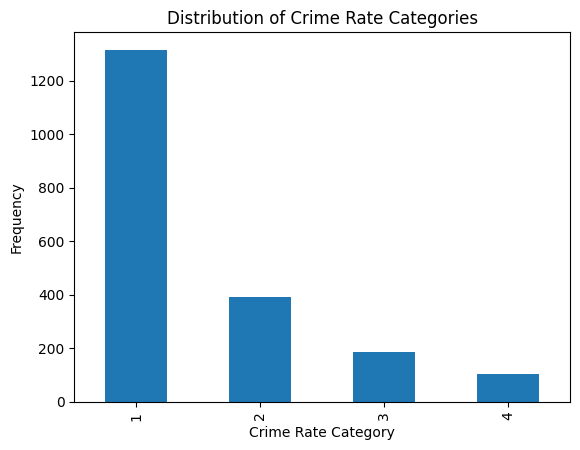

In [ ]:
frequency_table.plot(kind='bar')
plt.title("Distribution of Crime Rate Categories")
plt.ylabel("Frequency")
plt.xlabel("Crime Rate Category")

***Going into Training Remarks:*** Given that we have a higher distribution of Low Violent Crime cities, we will see that the accuracy will hinder a bit because there isn't enough training data for higher violent crime rated cities. On the positive side, our classifier will be very good at classifing low crime!



# **Random Forest Classifier Training And Validation (Supervised)**


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
'pctPopUnderPov,  pctLess9thGrade,  pctNotHSGrad,  pctEmploy'

X = training_df[['racePctBlack','racePctWhite','racePctAsian','racePctHisp','agePct12t21','agePct12t29','agePct16t24','agePct65up','pctUrban','medIncome','medFamInc','pctPopUnderPov','pctLess9thGrade','pctNotHSGrad','pctBSorMore','pctEmploy','numInShelters','numStreet','lemasTotalReg','policPerPop','policAvOTWorked','popDens','policBudgPerPop','lemasPctOfficDrugUn','lemasGangUnitDeploy']]

y = training_df['CrimeRateCategory']


**For our features we selected 25 out of the ~120 features that are in our dataset. These features are going to help our model take into account of demographics, socieconomic status, and other population demographics to predict our label which is Categorized Crime Rate (1, 2, 3, 4)**

In [ ]:
#y_train_class = pd.cut(y, bins=num_bins_label, labels=False)

In [ ]:
#Initializing 70-30 Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=92)

In [ ]:
param_grid = {'n_estimators': [10, 30, 50, 100, 150],
             'max_depth': [None, 10, 20],
             'min_samples_split': [2, 5, 10]}

***To maximize the performance of our model we are using a hyperparamter optimization technique called grid search which iterates through a list of different hyperparamters to find the best performing model. This will be very important for getting the most out of our model.***

In [ ]:
len(X_train), len(X_test)

(1395, 599)

In [ ]:
len(y_train), len(y_test)

(1395, 599)

In [ ]:
RFC = RandomForestClassifier()

In [ ]:
grid_search = GridSearchCV(RFC, param_grid)

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 30, 50, 100, 150]})

In [ ]:
#Selecting the best performing model after grid search
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_
best_params

{'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}

In [ ]:
predictions = best_rf.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, predictions)

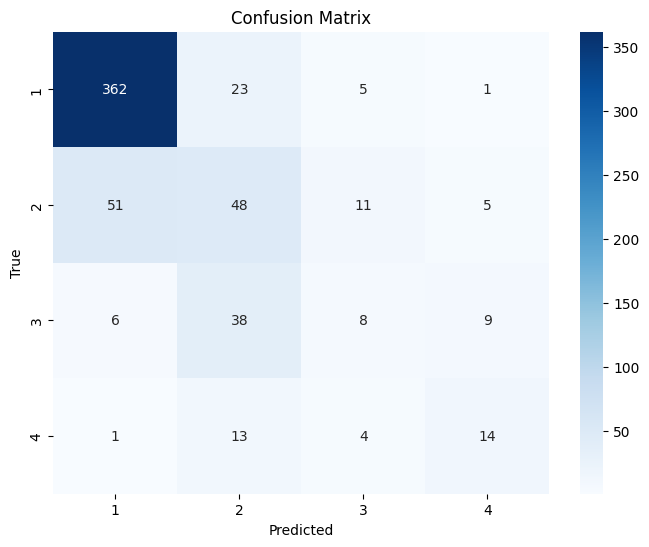

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Obervations:** After running the model, we created a confusion matrix using a heat map to show how well our model trained on our data. The model made a few predictions, the correct predictions are that 360 were correctly predicted for Low Crime Rate, 44 correct Predictions for Moderately Low Crime, 38 correct Predictions for Moderately High, and 13 correct predictions for High Crime Rate. In terms of incorrect predictions, 26 predictions of low crime rate were actually moderately low, 14 predictions of moderately low crime rate were actually moderately high crime rate, 10 predictions of Moderately high crime rate were actually High crime rate and 6 predictions that were vice versa. Overall, the model is doing a good job of predicting crime rate, but it is making mistakes for crime rates that aren't Low Crime related.

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.86      0.93      0.89       391
           2       0.39      0.42      0.41       115
           3       0.29      0.13      0.18        61
           4       0.48      0.44      0.46        32

    accuracy                           0.72       599
   macro avg       0.51      0.48      0.48       599
weighted avg       0.69      0.72      0.70       599



**Observations:** Let's break down the classification report by each crime rate category:

Low Crime Rate: The model is very good at predicting this class correctly, with a precision of 86% and a recall of 92%. This means that this model is NOT making many false positive or false negatives for this category.

Moderately Low Crime Rate: The model is doing less of a good job predicting this category given that it has a precision of 37% and a recall of 38%, this means that there more instances of false positives and false negatives.

Moderately High Crime Rate: The model is doing a poor job of predicting this category given that it has a precision of 29% and a recall of 16%. Heavy presence of false negatives and false positives.

High Crime Rate: The model is doing a fair job at predicting this category given that it has a precision of 51% and a recall of 41%. The are some instances of false negatives and false positive

In [ ]:
##Running Cross-Validation to ensure Accuaracy

In [ ]:
val_score = cross_val_score(grid_search, X, y, scoring="accuracy")

In [ ]:
print(f'Scores for each fold are: {val_score}')
print(f'Average Score: {"{:3f}".format(val_score.mean())}')

Scores for each fold are: [0.71428571 0.73934837 0.73684211 0.73433584 0.70351759]
Average Score: 0.725666


**In order to validate our accuracy from our training, we ran 5 fold cross validation to get the average valdiation score which is 72%. We believe this score is satisfactory given the training data that we were given.**

# **K-Means Clustering Training and Validation Stage (Unsupervised)**

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

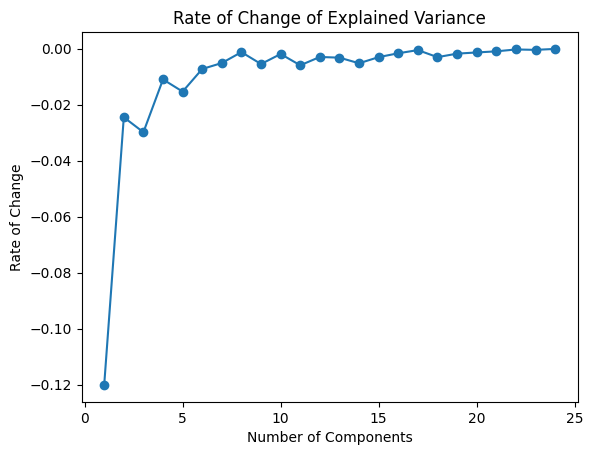

In [ ]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Choose the number of components you want to keep (e.g., 2 for 2D visualization)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_standardized)

# Plot the explained variance
# Assuming pca is already fitted
explained_variance = pca.explained_variance_ratio_

# Compute the rate of change
rate_of_change = [explained_variance[i] - explained_variance[i - 1] for i in range(1, len(explained_variance))]

# Plot the rate of change
plt.plot(range(1, len(explained_variance)), rate_of_change, marker='o')
plt.title('Rate of Change of Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Rate of Change')
plt.show()

**Observation:** For this graph, we decided to plot a line that describes the relationship between the rate of change and the rate of change of explained variance. The goal of this is to find how many PCA components were necessary to scale our training set since we are using high dimensional data. We found the number of n_components by finding where the rate of change starts to converge to 0, we found that it started around 15. This step is very important because it helps characterize the cluster’s variance for when we start labeling different cities with each cluster. Out of this graph we decided that we wanted 15 PCA components and we would only need the first one to conduct analysis on the variance of each feature.

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Apply PCA with the chosen number of components
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X_standardized)

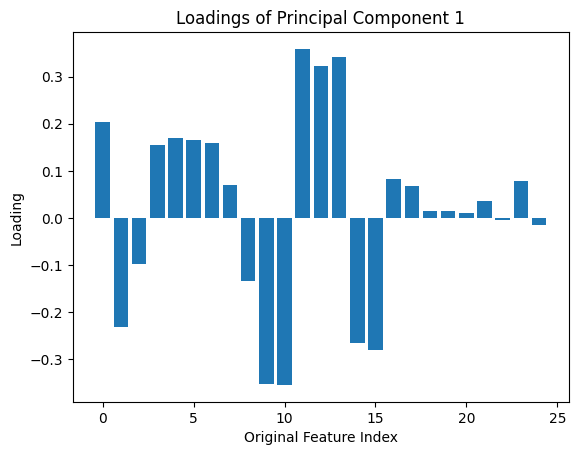

In [ ]:
# Access the loadings (eigenvectors)
loadings = pca.components_

# Visualize loadings for the first principal component
plt.bar(range(len(loadings[0])), loadings[0])
plt.title('Loadings of Principal Component 1')
plt.xlabel('Original Feature Index')
plt.ylabel('Loading')
plt.show()

**Observation:** For this graph, we wanted to show the correlation between variance in our data to each feature. The loadings axis represents the correlation between variance and the feature index. For example, our first feature index has a positive correlation with variance and our 10th feature index has a strong negative correlation with variance. This tells us the characteristics of each feature as it pertains to each cluster. This is important in understanding how each feature characterizes each crime category, and how different categories share similarities with one another.


In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
training_df['Cluster'] = labels

In [ ]:
cluster_category_mapping = {
    0: 1,
    1: 2,
    2: 3,
    3: 4,
}

training_df['CrimeCategoryClustering'] = training_df['Cluster'].map(cluster_category_mapping)

In [ ]:
training_df.drop('Cluster', axis=1).head()

,state,county,community,communityname,fold,population,householdsize,racePctBlack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInv,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,asianPerCap,otherPerCap,hispPerCap,numUnderPov,pctPopUnderPov,pctLess9thGrade,pctNotHSGrad,pctBSorMore,pctUnemployed,pctEmploy,pctEmplManu,pctEmplProfServ,pctOccupManu,pctOccupMgmtProf,malePctDivorce,malePctNevMarr,femalePctDiv,totalPctDiv,persPerFam,pctFam2Par,pctKids2Par,pctYoungKids2Par,pctTeen2Par,pctWorkMomYoungKids,pctWorkMom,numIlleg,pctIlleg,numIlleg.1,pctImmigRecent,pctImmigRec5,pctImmigRec8,pctImmigRec10,pctRecentImmig,pctRecImmig5,pctRecImmig8,pctRecImmig10,pctSpeakEngOnly,pctNotSpeakEngWell,pctLargHouseFam,pctLargHouseOccup,persPerOccupHous,persPerOwnOccHouse,persPerRentOccHouse,pctPersOwnOccup,pctPersDenceHous,pctHouseLess3BR,medNumBR,housVacant,pctHouseOccup,pctHouseOwnOcc,pctVacantBoarded,pctVacMore6Mos,medYrHousBuilt,pctHousNoPhone,pctWOFullPlumb,ownOccLowQuart,ownOccMedVal,ownOccHiQuart,rentLowQ,rentMedian,rentHighQ,medRent,medRentPctHousInc,medOwnCostPctInc,medOwnCostPctIncNoMtg,numInShelters,numStreet,pctForeignBorn,pctBornSameState,pctSameHouse85,pctSameCity85,lemasSwornFT,lemasSwFTPerPop,lemasSwFTFieldOps,lemasSwFTFieldPerPop,lemasTotalReg,lemasTotRegPerPop,policeReqPerOffic,policPerPop,racialMatchCommPol,pctPolicWhite,pctPolicBlack,pctPolicHisp,pctPolicAsian,pctPolicMinor,officAssgnDrugUnits,numKindsDrugsSeiz,policAvOTWorked,landArea,popDens,pctUsePubTrans,policCars,policOperBudg,lemasPctPolicOnPatr,lemasGangUnitDeploy,lemasGangUnitDeploy.1,lemasPctOfficDrugUn,policBudgPerPop,violentCrimesPerPop,CrimeRateCategory,CrimeCategoryClustering
0,8,NaN,NaN,Lakewoodcity,1.0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,0.75,0.75,0.35,0.55,0.59,0.61,0.56,0.74,0.76,0.04,0.14,0.03,0.24,0.27,0.37,0.39,0.07,0.07,0.08,0.08,0.89,0.06,0.14,0.13,0.33,0.39,0.28,0.55,0.09,0.51,0.5,0.21,0.71,0.52,0.05,0.26,0.65,0.14,0.06,0.22,0.19,0.18,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.030000,0.130000,0.960000,0.170000,0.060000,0.180000,0.440000,0.130000,0.940000,0.930000,0.03000,0.070000,0.100000,0.070000,0.020000,0.57000,0.290000,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20,1,1
1,53,NaN,NaN,Tukwilacity,1.0,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,0.91,1.00,0.29,0.43,0.47,0.60,0.39,0.46,0.53,0.00,0.24,0.01,0.52,0.62,0.64,0.63,0.25,0.27,0.25,0.23,0.84,0.10,0.16,0.10,0.17,0.29,0.17,0.26,0.20,0.82,0.0,0.02,0.79,0.24,0.02,0.25,0.65,0.16,0.00,0.21,0.20,0.21,0.42,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,0.069655,0.217461,0.924734,0.246332,0.097994,0.215204,0.343636,0.217492,0.689404,0.726959,0.22047,0.134859,0.114859,0.259185,0.075549,0.55605,0.305987,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67,3,1
2,24,NaN,NaN,Aberdeentown,1.0,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,0.71,0.70,0.45,0.42,0.44,0.43,0.43,0.71,0.67,0.01,0.46,0.00,0.07,0.06,0.15,0.19,0.02,0.02,0.04,0.05,0.88,0.04,0.20,0.20,0.46,0.52,0.43,0.42,0.15,0.51,0.5,0.01,0.86,0.41,0.29,0.30,0.52,0.47,0.45,0.18,0.17,0.16,0.27,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,0.069655,0.217461,0.924734,0.246332,0.097994,0.215204,0.343636,0.217492,0.689404,0.726959,0.22047,0.134859,0.114859,0.259185,0.075549,0.55605,0.305987,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43,2,3
3,34,

**Cluster Analysis**

---



In [ ]:
# Evaluate the silhouette score
silhouette_avg = silhouette_score(X_pca, labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.1820740422074413


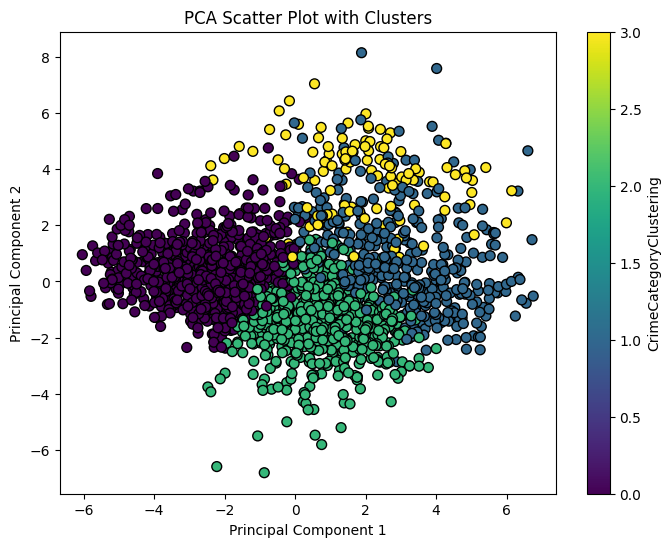

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', edgecolors='k', s=50)
plt.title('PCA Scatter Plot with Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='CrimeCategoryClustering')
plt.show()

**Observations**: This plot shows each category in the form of clusters and on the x and y axis we have 2 separate PCA components. The gradient bar basically tells us what color each of our categories represent. 0-Low Crime Rate, 1-Moderately Low Crime Rate, 2-Moderately High Crime Rate, 3-High Crime Rate. When looking at this graph, it’s important not to focus on the x and y axis values since they merely represent what value they coincide with in each PCA component. The idea of this graph is to show our silhouette score visually, which came out to around .18, which indicates that our clusters are very close to one another. When assessing our model, it’s showing that there is lot’s of similarities amongst the 4 different categories/clusters. Understanding the similarities and differences amongst the categories can help us develop ways to attack major issues that cause violent crime to rise, which is what we want to understand in terms of our project goals. This analysis is less about classification and more about how each category relates to one another, since unsupervised learning techniques aren’t typically used for classification purposes.


# **Actual vs Predicted Crime Rates**

In [ ]:
predictions = best_rf.predict(X_test)

comparison_df = pd.DataFrame()

comparison_df['city'] = training_df['communityname']
comparison_df['Crime Rate Category'] = training_df['CrimeRateCategory']
comparison_df['RFC Predict CR'] = best_rf.predict(X)
comparison_df['K-Means Predict CR'] = training_df['CrimeCategoryClustering']

In [ ]:
comparison_df.head()

,city,Crime Rate Category,RFC Predict CR,K-Means Predict CR
0,Lakewoodcity,1,1,1
1,Tukwilacity,3,1,1
2,Aberdeentown,2,2,3
3,Willingborotownship,1,1,1
4,Bethlehemtownship,1,1,1


Observation: Generally, the supervised model Random Forest was more accurate. This makes sense, due to the fact supervised models utilize labels. K-Means Clustering was generally less accurate due to its lack of labels. However, it was useful for understanding the relationships between certain categories.


For example, when trying to predict the crime rate of Burrillvilletown, which is 1, Random Forest got 1, while K-Means got 3. Even when RFC didn't get the exact crime rate, it was still closer than K-Means. For example, when trying to predict the crime rate of RedBankbourough, which is 1, Random Forest got 2, and K-Means got 3.

There we some instances where K-Means was right when Random Forest was wrong. When predicting LongBranchCity with a crime rate of 3, Random Forest got 2, while K-Means got 3.





# ***Overall Conclusion:***

---



Our analysis of crime rates and various socio-economic factors has provided valuable insights into how these variables interact. The positive correlation identified between socioeconomic features and violent crime rates underscores the nuanced relationship that exists within communities. Using methods such as Chi Squared Analysis, Pearson correlation coefficient hypothesis tests, and linear regression lines, we have successfully shown the significance of these correlations.

Our investigation into the demographic aspects has revealed a substantial correlation between certain demographic features and violent crime rates. Utilizing Pearson correlation coefficient hypothesis tests and examining linear regression lines for each race against crime rates, we found that for certain ethnic populations that suffered systemic racism among other systemic issues, there was a positive slope for violent crimes on the regression line as the population of those demographics increased, while there was a decrease with more privileged areas.

Our findings were surprising, as it indicated no correlation between the number of police officers per 100K and crime rates. Employing Chi Squared Analysis and exploring linear regression lines, we found that the correlation was 0.3402 which is not significant enough for us to claim correlation.

However, the exploration of police activity has yielded intriguing results. We identified a correlation between police activity and the percentage of people living under the poverty line, shedding light on the socio-economic factors that influence law enforcement engagement. We found this by plotting linear regression lines and found that as the data points increased, so did the slope of the linear regression line.

Furthermore, our investigation into the urban environment and police presence revealed an unexpected result – no discernible correlation between living in an "urban" area and police presence. The linear regression lines did not have any data that fit above or below it, showing that there is significant correlation between police presence and urban environment.

Our project has not only provided statistical evidence but has also raised thought-provoking questions about the influences on crime rates. When comparing the Relationship between Non-high school graduates, unemployment, and violent crimes via a scatter plot, the number of violentCrimesPerPop was at the highest when the percentage of non-high school graduates and unemployment rates were the highest. This research serves as a call to action for communities to be more proactive in keeping their children in school. By doing so, they can positively impact not only the future of individuals but also contribute to the overall well-being and safety of the community.

The insights gained from this study offer valuable guidance for policymakers, educators, and community leaders in formulating strategies that address the root causes of crime and promote sustainable community development. Insights such as the higher the number of police requests coming in directly lead to lower crime rates can be used to help evaluate the Police force and and educate policy makers on what to continue to fund and support and what needs to be changed.